# Size reduction training (as is, no trimming) + class weights

In [ ]:
!pip -q install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 66.5 MB/s eta 0:00:00


In [ ]:
import glob
import json
import numpy as np
import os
from PIL import Image
import random
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torchmetrics import JaccardIndex, F1Score
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [ ]:
os.makedirs("training_data/data3d/train/cts", exist_ok=True)
os.makedirs("training_data/data3d/train/masks", exist_ok=True)
os.makedirs("training_data/data3d/val/cts", exist_ok=True)
os.makedirs("training_data/data3d/val/masks", exist_ok=True)

In [ ]:
def create3d(patient_path: str, split_group: str) -> tuple[str, str]:

    data = np.load(patient_path)
    image = data['image']
    image = np.transpose(image, axes=(2, 0, 1))  # -> (D x H x W)
    mask = data['mask']
    mask = np.transpose(mask, axes=(2, 0, 1))  # -> (D x H x W)

    patient_id = os.path.split(patient_path)[1].split('.')[0]

    # Stack 3D slices and convert them into torch tensors
    image = torch.as_tensor(image)
    image = image.type(torch.FloatTensor)

    mask = torch.as_tensor(mask)

    desired_height = 128
    current_height = image.shape[1]
    height_factor = desired_height / current_height

    desired_width = 128
    current_width = image.shape[2]
    width_factor = desired_width / current_width

    desired_depth = 128
    current_depth = image.shape[0]
    depth_factor = desired_depth / current_depth

    # Create and save resized 3D ct tensor
    # order=1 - bi-linear interpolation
    ct_3d = ndimage.zoom(image, zoom=(depth_factor, height_factor, width_factor), order=1)
    ct_path = os.path.join("training_data", "data3d", split_group, "cts", patient_id + "_ct.pt")
    torch.save(ct_3d, ct_path)  # -> (D x H x W)

    desired_height = 256    #####################
    current_height = image.shape[1]
    height_factor = desired_height / current_height

    desired_width = 256    #####################
    current_width = image.shape[2]
    width_factor = desired_width / current_width

    desired_depth = 256    #####################
    current_depth = image.shape[0]
    depth_factor = desired_depth / current_depth

    # Create and save resized 3D mask tensor
    # order=0 - nearest interpolation
    mask_3d = ndimage.zoom(mask, zoom=(depth_factor, height_factor, width_factor), order=0)
    mask_path = os.path.join("training_data", "data3d", split_group, "masks", patient_id + "_mask.pt")
    torch.save(mask_3d, mask_path)  # -> (D x H x W)

    return ct_path, mask_path

In [ ]:
random.seed(42)
ids = [i for i in range(1, 590)]
random.shuffle(ids)
split_index = int(0.8 * len(ids))

train_ids = ids[:split_index]
val_ids = ids[split_index:]

dataset_split = {id: 'train' for id in train_ids}
dataset_split.update({id: 'val' for id in val_ids})

print(f"Train IDs: {len(train_ids)}")
print(f"Validation IDs: {len(val_ids)}")
print(f"Total IDs: {len(dataset_split)}")

Train IDs: 471
Validation IDs: 118
Total IDs: 589


In [ ]:
print(dataset_split)

{491: 'train', 570: 'train', 149: 'train', 154: 'train', 188: 'train', 201: 'train', 231: 'train', 84: 'train', 585: 'train', 412: 'train', 444: 'train', 470: 'train', 60: 'train', 464: 'train', 378: 'train', 384: 'train', 486: 'train', 303: 'train', 417: 'train', 537: 'train', 241: 'train', 532: 'train', 316: 'train', 286: 'train', 304: 'train', 173: 'train', 179: 'train', 266: 'train', 355: 'train', 308: 'train', 427: 'train', 571: 'train', 407: 'train', 13: 'train', 93: 'train', 459: 'train', 101: 'train', 185: 'train', 22: 'train', 119: 'train', 315: 'train', 544: 'train', 514: 'train', 484: 'train', 89: 'train', 428: 'train', 405: 'train', 507: 'train', 478: 'train', 219: 'train', 450: 'train', 320: 'train', 141: 'train', 202: 'train', 401: 'train', 248: 'train', 255: 'train', 538: 'train', 262: 'train', 317: 'train', 381: 'train', 132: 'train', 372: 'train', 76: 'train', 165: 'train', 339: 'train', 156: 'train', 131: 'train', 357: 'train', 180: 'train', 177: 'train', 148: 'train'

In [ ]:
# 14 минут

patients_paths = sorted(glob.glob("drive/MyDrive/npz_files/*"))
patients_count = len(patients_paths)

for i, pth in enumerate(patients_paths):
    if (i + 1) % 50 == 0 or i == 0:
        print("Processing patient {}/{} ...".format(i + 1, patients_count))
    paths3d = create3d(pth, dataset_split[i + 1])

Processing patient 1/589 ...
Processing patient 50/589 ...
Processing patient 100/589 ...
Processing patient 150/589 ...
Processing patient 200/589 ...
Processing patient 250/589 ...
Processing patient 300/589 ...
Processing patient 350/589 ...
Processing patient 400/589 ...
Processing patient 450/589 ...
Processing patient 500/589 ...
Processing patient 550/589 ...


(128, 128, 128) (256, 256, 256)


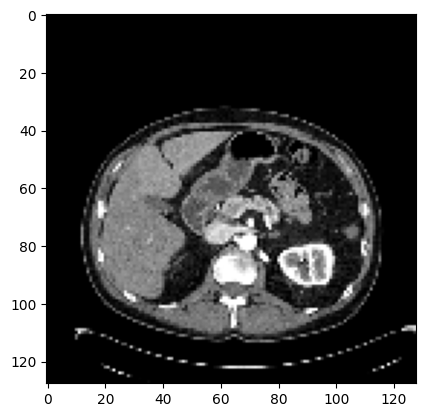

In [ ]:
import matplotlib.pyplot as plt

img = torch.load("training_data/data3d/train/cts/pancreas_0570_ct.pt")
mask = torch.load("training_data/data3d/train/masks/pancreas_0570_mask.pt")
print(img.shape, mask.shape)
plt.imshow(img[60,:,:], cmap="gray")

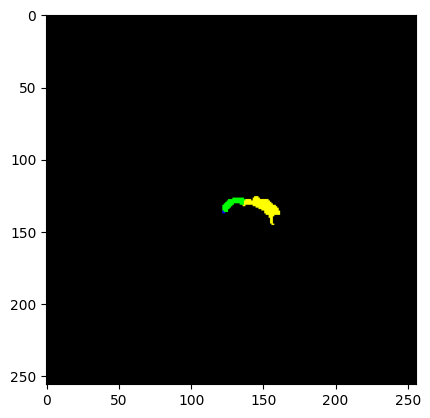

In [ ]:
rgb_images = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
rgb_images[mask == 0] = (0,0,0)
rgb_images[mask == 1] = (0,0,255)
rgb_images[mask == 2] = (0,255,0)
rgb_images[mask == 3] = (255,255,0)
rgb_images[mask == 4] = (255,0,0)
plt.imshow(rgb_images[120,:,:])

In [ ]:
import os
import torch

def check_files(directory, expected_shape_cts, expected_shape_masks):
    """
    Checking files in a given directory for compliance with expected sizes.

    :param directory: Directory with training data
    :param expected_shape_cts: Expected size for cts files
    :param expected_shape_masks: Expected size for masks files
    """
    subdirs = ["train", "val"]
    data_types = ["cts", "masks"]

    for subdir in subdirs:
        for data_type in data_types:
            path = os.path.join(directory, subdir, data_type)
            expected_shape = expected_shape_cts if data_type == "cts" else expected_shape_masks

            for root, _, files in os.walk(path):
                for file in files:
                    if file.endswith(".pt"):
                        file_path = os.path.join(root, file)
                        try:
                            data = torch.load(file_path)
                            data_shape = data.shape

                            if data_shape != expected_shape:
                                print(f"Файл {file_path} имеет размер {data_shape}, но ожидается {expected_shape}")
                        except Exception as e:
                            print(f"Ошибка при загрузке файла {file_path}: {e}")

# Setting parameters
directory = "training_data/data3d"
expected_shape_cts = (128, 128, 128)
expected_shape_masks = (256, 256, 256)

# Start checking
check_files(directory, expected_shape_cts, expected_shape_masks)

Файл training_data/data3d/train/masks/pancreas_0342_mask.pt имеет размер (222, 256, 256), но ожидается (256, 256, 256)


In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=5, features=16, dropout_rate=0.3):
        super().__init__()

        # Encoder
        self.encoder1 = UNet3D.conv_block(in_channels, features)
        self.encoder2 = UNet3D.conv_block(features, features * 2)
        self.encoder3 = UNet3D.conv_block(features * 2, features * 4)
        self.encoder4 = UNet3D.conv_block(features * 4, features * 8)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = UNet3D.conv_block(features * 4, features * 8)

        # Decoder
        self.upconv4 = nn.ConvTranspose3d(features * 16, features * 16, kernel_size=2, stride=2)
        self.decoder4 = UNet3D.conv_block(features * 24, features * 8)
        self.upconv3 = nn.ConvTranspose3d(features * 8, features * 8, kernel_size=2, stride=2)
        self.decoder3 = UNet3D.conv_block(features * 12, features * 4)
        self.upconv2 = nn.ConvTranspose3d(features * 4, features * 4, kernel_size=2, stride=2)
        self.decoder2 = UNet3D.conv_block(features * 6, features * 2)
        self.upconv1 = nn.ConvTranspose3d(features * 2, features * 2, kernel_size=2, stride=2)
        self.decoder1 = UNet3D.conv_block(features * 3, features)

        # Output layer
        self.last_conv = nn.Conv3d(in_channels=features, out_channels=out_channels, kernel_size=1)
        self.last_upconv1 = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=2, stride=2)
        # self.last_upconv2 = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=2, stride=2)   #################

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):

        # Encoding path
        enc1_copy = self.encoder1(x)
        enc1 = self.dropout(self.pool(enc1_copy))
        enc2_copy = self.encoder2(enc1)
        enc2 = self.dropout(self.pool(enc2_copy))
        enc3_copy = self.encoder3(enc2)
        enc3 = self.dropout(self.pool(enc3_copy))
        # enc4_copy = self.encoder4(enc3)
        # enc4 = self.dropout(self.pool(enc4_copy))

        # Bottleneck
        # bn = self.bottleneck(enc4)
        bn = self.bottleneck(enc3)

        # Decoding path
        # dec4 = self.dropout(self.upconv4(bn))
        # dec4 = self.decoder4(torch.cat((dec4, enc4_copy), dim=1))
        dec3 = self.dropout(self.upconv3(bn))
        dec3 = self.decoder3(torch.cat((dec3, enc3_copy), dim=1))
        dec2 = self.dropout(self.upconv2(dec3))
        dec2 = self.decoder2(torch.cat((dec2, enc2_copy), dim=1))
        dec1 = self.dropout(self.upconv1(dec2))
        dec1 = self.decoder1(torch.cat((dec1, enc1_copy), dim=1))
        output = self.last_conv(dec1)
        output = self.last_upconv1(output)
        # output = self.last_upconv2(output)    ###########################

        return output

    @staticmethod
    def conv_block(in_features, out_features):
        return nn.Sequential(
            nn.Conv3d(
                in_channels=in_features,
                out_channels=out_features,
                kernel_size=3,
                padding=1
                ),
            nn.BatchNorm3d(num_features=out_features),
            nn.ReLU(),
            nn.Conv3d(
                in_channels=out_features,
                out_channels=out_features,
                kernel_size=3,
                padding=1
                ),
            nn.BatchNorm3d(num_features=out_features),
            nn.ReLU()
        )

In [ ]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet3D().to(device)
summary(model, (1, 128, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 16, 128, 128, 128]             448
       BatchNorm3d-2    [-1, 16, 128, 128, 128]              32
              ReLU-3    [-1, 16, 128, 128, 128]               0
            Conv3d-4    [-1, 16, 128, 128, 128]           6,928
       BatchNorm3d-5    [-1, 16, 128, 128, 128]              32
              ReLU-6    [-1, 16, 128, 128, 128]               0
         MaxPool3d-7       [-1, 16, 64, 64, 64]               0
           Dropout-8       [-1, 16, 64, 64, 64]               0
            Conv3d-9       [-1, 32, 64, 64, 64]          13,856
      BatchNorm3d-10       [-1, 32, 64, 64, 64]              64
             ReLU-11       [-1, 32, 64, 64, 64]               0
           Conv3d-12       [-1, 32, 64, 64, 64]          27,680
      BatchNorm3d-13       [-1, 32, 64, 64, 64]              64
             ReLU-14       [-1, 32, 64,

In [ ]:
class PartSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=False):
        self.root_dir = root_dir
        self.cts = sorted(os.listdir(os.path.join(self.root_dir, "cts")))
        self.masks = sorted(os.listdir(os.path.join(self.root_dir, "masks")))
        self.transform = transform
        assert len(self.cts) == len(self.masks), "Количество изображений и масок должно совпадать"

    def __len__(self):
        return len(self.cts)

    def __getitem__(self, idx):
        # load tensors
        image_path = os.path.join(self.root_dir, "cts", self.cts[idx])
        mask_path = os.path.join(self.root_dir, "masks", self.masks[idx])
        # add channel dimension
        image = torch.load(image_path)
        image = torch.from_numpy(image).unsqueeze(0)     # -> shape = (C, D, H, W)
        mask = torch.load(mask_path)
        mask = torch.from_numpy(mask).unsqueeze(0)   # -> shape = (C, D, H, W)

        # scale ct images
        image = image / 255.0

        # restore data type after transformation
        image = image.type(torch.FloatTensor)
        mask = mask.type(torch.IntTensor)

        return image, mask

In [ ]:
def save_dicts(losses, metrics, file_path):
    with open(file_path, "w") as f:
        json.dump({"losses": losses, "metrics": metrics}, f)

def train(model, train_dl, val_dl, n_epochs, optimizer, criterion, device):
    iouscore = JaccardIndex(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in JaccardIndex)
    f1score = F1Score(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in F1Score)
    losses = {"train": [], "val": []}
    metrics = {"IoU": {"train": [], "val": []},
               "F1score": {"train": [], "val": []}}
    show_every = 10
    for epoch in tqdm(range(1, n_epochs+1), total=n_epochs+1):
        print(f"=== Epoch #{epoch} ===")

        ###################
        # Train the model #
        ###################
        model.train()
        train_loss = 0.0
        per_batch_train_iou = []
        per_batch_train_f1 = []
        print("=== Training ===")
        for batch_idx, (data, target) in enumerate(train_dl):
            data = data.to(device)
            target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
            target = target.to(torch.long)
            if batch_idx % show_every == 0:
                print(f"{batch_idx + 1} / {len(train_dl)} ...")
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Save average loss
            train_loss += (loss / len(train_dl)).item()
            # Save metrics
            per_batch_train_iou.append(iouscore(output, target).tolist())
            per_batch_train_f1.append(f1score(output, target).tolist())
            # Print first epoch statistics
            if epoch == 1 and (batch_idx % show_every == 0 or batch_idx == 0):
                print(
                    "Batch IDX {}: Training Loss: {:.4f} \tTrain IoU: {} \tTrain F1: {}".format(
                        batch_idx,
                        train_loss,
                        per_batch_train_iou[-1],
                        per_batch_train_f1[-1]
                    ))
        losses["train"].append(train_loss)
        metrics["IoU"]["train"].append(np.mean(per_batch_train_iou, axis=0).tolist())
        metrics["F1score"]["train"].append(np.mean(per_batch_train_f1, axis=0).tolist())

        ######################
        # Validate the model #
        ######################
        print("=== Validation ===")
        valid_loss = 0.0
        per_batch_val_iou = []
        per_batch_val_f1 = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_dl):
                if batch_idx % show_every == 0:
                    print(f"{batch_idx + 1} / {len(val_dl)} ...")
                data = data.to(device)
                target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
                target = target.to(torch.long)
                output = model(data)
                # Save average loss
                loss = criterion(output, target)
                valid_loss += (loss / len(val_dl)).item()
                # Save metrics
                per_batch_val_iou.append(iouscore(output, target).tolist())
                per_batch_val_f1.append(f1score(output, target).tolist())
            losses["val"].append(valid_loss)
            val_iou = np.mean(per_batch_val_iou, axis=0).tolist()
            val_f1 = np.mean(per_batch_val_f1, axis=0).tolist()
            metrics["IoU"]["val"].append(val_iou)
            metrics["F1score"]["val"].append(val_f1)

        # Save model
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"DSUNetCW{epoch}epochsCP.pt")
        # Save losses and metrics
        save_dicts(losses, metrics, "history.json")

        # Print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tValidation F1 Score: {} \tValidation IoU: {}".format(
                epoch,
                train_loss,
                valid_loss,
                val_f1,
                val_iou
            ))

    # Save the final model
    torch.save(model.state_dict(), "DSUNetCWcp.pt")

    return model

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!rm -r training_data/data3d/train/cts/.ipynb_checkpoints
!rm -r training_data/data3d/train/masks/.ipynb_checkpoints

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

In [ ]:
batch_size = 4
root_dir = os.path.join("training_data", "data3d")
dataset_train = PartSegmentationDataset(os.path.join(root_dir, "train"), transform=False) #######
dataset_val = PartSegmentationDataset(os.path.join(root_dir, "val"), transform=False)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute the class weights for loss function
# Classes reminder: 0-background, 1-head, 2-neck, 3-body, 4-tail
print("Computing the class weights ...")
y = torch.load("training_data/data3d/train/masks/pancreas_0356_mask.pt").flatten()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the model and the training parameters
model = UNet3D().to(device)
n_epochs = 200
# try reduction="sum" if gradients are too small
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, reduction="mean")
# criterion = torch.nn.CrossEntropyLoss(reduction="mean")
learning_rate = 1e-3  # 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
model = train(
    model, train_dataloader, val_dataloader,
    n_epochs, optimizer, criterion, device
)

Computing the class weights ...


  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 118 ...
Batch IDX 0: Training Loss: 0.0137 	Train IoU: [0.04203334078192711, 0.0009768075542524457, 0.00010228803148493171, 0.0005442819674499333, 0.0005518405232578516] 	Train F1: [0.0806756243109703, 0.0019517086911946535, 0.00020455513731576502, 0.0010879718465730548, 0.0011030723107978702]
11 / 118 ...
Batch IDX 10: Training Loss: 0.1495 	Train IoU: [0.07591826468706131, 0.0018936039414256811, 8.074266952462494e-05, 0.0003912529500667006, 0.0006074252305552363] 	Train F1: [0.1411227583885193, 0.0037800499703735113, 0.0001614723150851205, 0.0007821998442523181, 0.001214112970046699]
21 / 118 ...
Batch IDX 20: Training Loss: 0.2826 	Train IoU: [0.07554923743009567, 0.002140552969649434, 0.00011665935744531453, 0.00041057815542444587, 0.0004447530081961304] 	Train F1: [0.14048492908477783, 0.004271961282938719, 0.00023329153191298246, 0.0008208192884922028, 0.0008891106117516756]
31 / 118 ...
Batch IDX 30: Training Loss: 0.4105 	Train IoU: [0.0162

  0%|          | 1/201 [03:16<10:55:35, 196.68s/it]

Epoch: 1 	Training Loss: 1.1195 	Validation Loss: 0.7542 	Validation F1 Score: [0.24382901340723037, 0.009602023692180713, 0.00047380183774900313, 0.0036381923942826687, 0.023080017045140268] 	Validation IoU: [0.13894491319855054, 0.004826808565606674, 0.00023696443410396265, 0.0018226714882378777, 0.011705830646678805]
=== Epoch #2 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  1%|          | 2/201 [06:16<10:18:56, 186.61s/it]

Epoch: 2 	Training Loss: 0.5903 	Validation Loss: 0.5045 	Validation F1 Score: [0.9284413794676463, 0.020778024941682814, 0.025966809876263142, 0.0417307548224926, 0.026156796763340633] 	Validation IoU: [0.8665606757005055, 0.01050780862569809, 0.01316556849827369, 0.021359191400309403, 0.013295956359555324]
=== Epoch #3 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  1%|▏         | 3/201 [09:17<10:07:21, 184.05s/it]

Epoch: 3 	Training Loss: 0.4165 	Validation Loss: 0.5217 	Validation F1 Score: [0.884771611293157, 0.02268738280981779, 0.0041596330741109945, 0.01653969557955861, 0.02730690250173211] 	Validation IoU: [0.7935985267162323, 0.01149684440655013, 0.00208451128564775, 0.00834319560478131, 0.013888758902127544]
=== Epoch #4 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  2%|▏         | 4/201 [12:18<10:00:30, 182.89s/it]

Epoch: 4 	Training Loss: 0.3568 	Validation Loss: 0.3495 	Validation F1 Score: [0.9849862237771352, 0.20749148925145466, 0.06506766726573308, 0.08491401759286722, 0.06801345391819874] 	Validation IoU: [0.9704308072725932, 0.1166316012541453, 0.033736507222056386, 0.0444499583914876, 0.03548290049657225]
=== Epoch #5 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  2%|▏         | 5/201 [15:19<9:55:48, 182.39s/it] 

Epoch: 5 	Training Loss: 0.3063 	Validation Loss: 0.7639 	Validation F1 Score: [0.9951647579669952, 0.44010086357593536, 0.254693540930748, 0.34613452305396397, 0.09929634978373846] 	Validation IoU: [0.9903804202874501, 0.28682370434204735, 0.14771586805582046, 0.21238445167740186, 0.05270455206433932]
=== Epoch #6 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  3%|▎         | 6/201 [18:21<9:51:51, 182.11s/it]

Epoch: 6 	Training Loss: 0.2939 	Validation Loss: 0.3000 	Validation F1 Score: [0.976766699552536, 0.1628193236887455, 0.051771694980561736, 0.07432419434189796, 0.0359482585452497] 	Validation IoU: [0.9546225627263387, 0.08909904360771179, 0.026643029258896906, 0.0386716974278291, 0.018362550577148796]
=== Epoch #7 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  3%|▎         | 7/201 [21:22<9:47:58, 181.85s/it]

Epoch: 7 	Training Loss: 0.2581 	Validation Loss: 0.3293 	Validation F1 Score: [0.9862267712752024, 0.17453606973091762, 0.08311159064372381, 0.11890267804265023, 0.07038883386800686] 	Validation IoU: [0.9728494683901469, 0.09630897579093774, 0.04358219547818105, 0.06343167026837666, 0.036702020559459925]
=== Epoch #8 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  4%|▍         | 8/201 [24:23<9:44:02, 181.57s/it]

Epoch: 8 	Training Loss: 0.2625 	Validation Loss: 0.3214 	Validation F1 Score: [0.9712555646896363, 0.06365848320225874, 0.04856285912295182, 0.09548587749401728, 0.035591764065126576] 	Validation IoU: [0.944156535466512, 0.0329764861613512, 0.02493890719488263, 0.050264257627228894, 0.01817902605980635]
=== Epoch #9 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  4%|▍         | 9/201 [27:25<9:41:01, 181.57s/it]

Epoch: 9 	Training Loss: 0.2552 	Validation Loss: 0.3441 	Validation F1 Score: [0.950082540512085, 0.0369502783442537, 0.02141959738607208, 0.059319684530297914, 0.03000808780392011] 	Validation IoU: [0.9049825330575307, 0.018867326155304908, 0.01083654457082351, 0.03064673822373152, 0.015295547060668468]
=== Epoch #10 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  5%|▍         | 10/201 [30:26<9:37:56, 181.55s/it]

Epoch: 10 	Training Loss: 0.2596 	Validation Loss: 0.2994 	Validation F1 Score: [0.9564965864022573, 0.04048383751263221, 0.018460884566108386, 0.0789084895203511, 0.03801417220383883] 	Validation IoU: [0.9166881461938222, 0.02070282402758797, 0.009322897034386794, 0.041153424667815366, 0.019454237911850213]
=== Epoch #11 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  5%|▌         | 11/201 [33:27<9:34:18, 181.36s/it]

Epoch: 11 	Training Loss: 0.2423 	Validation Loss: 0.2540 	Validation F1 Score: [0.9841477572917938, 0.17732350006699563, 0.06911418475210666, 0.1097596896191438, 0.05926918803403775] 	Validation IoU: [0.9688119908173879, 0.09810858344038327, 0.0359129344423612, 0.058212700362006826, 0.030685729657610256]
=== Epoch #12 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  6%|▌         | 12/201 [36:28<9:30:48, 181.21s/it]

Epoch: 12 	Training Loss: 0.2387 	Validation Loss: 0.3161 	Validation F1 Score: [0.9511060436566671, 0.10746810336907704, 0.07019129569331804, 0.0950516956547896, 0.012318345500777166] 	Validation IoU: [0.906846676270167, 0.05713331376512845, 0.036495499995847544, 0.050023852350811165, 0.006204312993213534]
=== Epoch #13 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  6%|▋         | 13/201 [39:29<9:27:41, 181.18s/it]

Epoch: 13 	Training Loss: 0.2272 	Validation Loss: 0.4142 	Validation F1 Score: [0.9900835057099661, 0.3834987719853719, 0.1646523860593637, 0.1701748251914978, 0.059581284690648315] 	Validation IoU: [0.9803746283054352, 0.24006045013666152, 0.09056792433063189, 0.0935474621752898, 0.030884227513646088]
=== Epoch #14 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  7%|▋         | 14/201 [42:30<9:24:20, 181.07s/it]

Epoch: 14 	Training Loss: 0.2372 	Validation Loss: 0.2723 	Validation F1 Score: [0.9492384831110636, 0.03869020286947489, 0.013383352399493257, 0.060628908003369966, 0.0363813036121428] 	Validation IoU: [0.9035244623819987, 0.019764532707631587, 0.006742749324378868, 0.031311528198421, 0.01858663416157166]
=== Epoch #15 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  7%|▋         | 15/201 [45:31<9:21:24, 181.10s/it]

Epoch: 15 	Training Loss: 0.2321 	Validation Loss: 0.3040 	Validation F1 Score: [0.9607995569705963, 0.08564736011127631, 0.03076710576812426, 0.04624100004633268, 0.023981286957859994] 	Validation IoU: [0.9246057053407033, 0.04497005908439557, 0.015643079734096923, 0.023704842384904622, 0.012166730407625437]
=== Epoch #16 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  8%|▊         | 16/201 [48:32<9:18:18, 181.07s/it]

Epoch: 16 	Training Loss: 0.2368 	Validation Loss: 0.2708 	Validation F1 Score: [0.9829418440659841, 0.13635945245623587, 0.06552314758300781, 0.12630093370874723, 0.05644037003318469] 	Validation IoU: [0.9664774517218272, 0.07369489657382171, 0.03397860446323951, 0.06761460714042186, 0.02918827018390099]
=== Epoch #17 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  8%|▊         | 17/201 [51:33<9:15:10, 181.04s/it]

Epoch: 17 	Training Loss: 0.2417 	Validation Loss: 0.2563 	Validation F1 Score: [0.9870165288448334, 0.1762127896149953, 0.10036122761666774, 0.1424423910677433, 0.07141879921158155] 	Validation IoU: [0.9743768473466238, 0.09733748013774554, 0.05309921856969595, 0.07696825849513213, 0.03727630665525794]
=== Epoch #18 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  9%|▉         | 18/201 [54:34<9:12:21, 181.10s/it]

Epoch: 18 	Training Loss: 0.2137 	Validation Loss: 0.2588 	Validation F1 Score: [0.9851868927478791, 0.13923233076930047, 0.06880287465949854, 0.14238616997996967, 0.07053221066792806] 	Validation IoU: [0.9708166142304738, 0.07532418482005596, 0.035766134845713775, 0.0769774409631888, 0.03679169761016965]
=== Epoch #19 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  9%|▉         | 19/201 [57:34<9:08:04, 180.68s/it]

Epoch: 19 	Training Loss: 0.2002 	Validation Loss: 0.2437 	Validation F1 Score: [0.9800638357798258, 0.11956234847505888, 0.0711392259846131, 0.1145629808306694, 0.04600934019933144] 	Validation IoU: [0.9609277963638305, 0.06393036842346192, 0.03700216977546612, 0.060946196069320044, 0.02364434034874042]
=== Epoch #20 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 10%|▉         | 20/201 [1:00:35<9:05:19, 180.77s/it]

Epoch: 20 	Training Loss: 0.1975 	Validation Loss: 0.2785 	Validation F1 Score: [0.9723260740439097, 0.08398131082455317, 0.07292155834535757, 0.08954223146041235, 0.03148431843146682] 	Validation IoU: [0.9461664040883382, 0.04403804515798886, 0.03795427375783523, 0.046990641454855604, 0.016051583224907517]
=== Epoch #21 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 10%|█         | 21/201 [1:03:36<9:02:35, 180.86s/it]

Epoch: 21 	Training Loss: 0.1964 	Validation Loss: 0.2920 	Validation F1 Score: [0.9783808310826619, 0.12648049692312877, 0.05650146311769883, 0.09058099302152793, 0.04217949643110235] 	Validation IoU: [0.9577018002669017, 0.0679726965725422, 0.029143709875643253, 0.04757201379785935, 0.021651148935779928]
=== Epoch #22 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 11%|█         | 22/201 [1:06:37<8:59:07, 180.71s/it]

Epoch: 22 	Training Loss: 0.2189 	Validation Loss: 0.2954 	Validation F1 Score: [0.9749729772408803, 0.13138810048500696, 0.04752650217463573, 0.08480950258672237, 0.03397619323804975] 	Validation IoU: [0.9511893232663472, 0.0707685362547636, 0.024389500760783753, 0.04438006766140461, 0.017352664703503252]
=== Epoch #23 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 11%|█▏        | 23/201 [1:09:36<8:54:55, 180.31s/it]

Epoch: 23 	Training Loss: 0.1876 	Validation Loss: 0.3114 	Validation F1 Score: [0.9865801711877187, 0.2032618080576261, 0.1241298737625281, 0.14808192004760107, 0.05671303452303012] 	Validation IoU: [0.973525466521581, 0.11412600154678026, 0.06650000500182311, 0.08025024669865767, 0.029341048219551642]
=== Epoch #24 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 12%|█▏        | 24/201 [1:12:35<8:50:59, 180.00s/it]

Epoch: 24 	Training Loss: 0.1918 	Validation Loss: 0.3085 	Validation F1 Score: [0.9906570653120677, 0.21640847474336625, 0.12548535565535227, 0.19494727477431298, 0.09618077352643013] 	Validation IoU: [0.981494814157486, 0.12246675665179889, 0.06733472595612208, 0.10855948353807131, 0.05098426813880603]
=== Epoch #25 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 12%|█▏        | 25/201 [1:15:36<8:48:34, 180.19s/it]

Epoch: 25 	Training Loss: 0.1842 	Validation Loss: 0.3145 	Validation F1 Score: [0.9890061060587565, 0.2161162368953228, 0.1418317866822084, 0.17005989799896876, 0.07050079392890135] 	Validation IoU: [0.978259281317393, 0.12243796437978745, 0.07684220025936762, 0.09325506649911404, 0.03672136012464762]
=== Epoch #26 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 13%|█▎        | 26/201 [1:18:37<8:46:36, 180.55s/it]

Epoch: 26 	Training Loss: 0.2012 	Validation Loss: 0.2768 	Validation F1 Score: [0.9853156328201294, 0.17377954522768657, 0.08524411643544832, 0.14055620307723682, 0.05711597576737404] 	Validation IoU: [0.9710687855879466, 0.09579717268546423, 0.04467737364272276, 0.07590808806320032, 0.029557084074864785]
=== Epoch #27 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 13%|█▎        | 27/201 [1:21:37<8:43:21, 180.47s/it]

Epoch: 27 	Training Loss: 0.1704 	Validation Loss: 0.2843 	Validation F1 Score: [0.9869098087151845, 0.13936082820097606, 0.09293132436772188, 0.16155204350749652, 0.07992236160983641] 	Validation IoU: [0.9741682151953379, 0.07535508386790753, 0.0489295062298576, 0.08832333199679851, 0.04195257863029837]
=== Epoch #28 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 14%|█▍        | 28/201 [1:24:38<8:40:44, 180.61s/it]

Epoch: 28 	Training Loss: 0.1761 	Validation Loss: 0.2836 	Validation F1 Score: [0.9899787048498789, 0.1600891262292862, 0.11728745164970557, 0.21520726929108303, 0.10617302209138871] 	Validation IoU: [0.9801637828350067, 0.0876397967338562, 0.0626086459805568, 0.12122770672043165, 0.05666287044684092]
=== Epoch #29 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 14%|█▍        | 29/201 [1:27:40<8:38:23, 180.84s/it]

Epoch: 29 	Training Loss: 0.1691 	Validation Loss: 0.2940 	Validation F1 Score: [0.979118158419927, 0.14088605095942816, 0.034366524095336595, 0.11367451151212056, 0.04650068984677394] 	Validation IoU: [0.9591243843237559, 0.07641533191005388, 0.0175153405405581, 0.060426785796880725, 0.023884911617885033]
=== Epoch #30 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 15%|█▍        | 30/201 [1:30:41<8:35:24, 180.84s/it]

Epoch: 30 	Training Loss: 0.1947 	Validation Loss: 0.3398 	Validation F1 Score: [0.979422535498937, 0.14902493432164193, 0.1110303188363711, 0.19897315402825674, 0.03075543393691381] 	Validation IoU: [0.9596993823846182, 0.08104669526219369, 0.05908080525696278, 0.11095078885555268, 0.015658737951889636]
=== Epoch #31 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 15%|█▌        | 31/201 [1:33:41<8:32:18, 180.82s/it]

Epoch: 31 	Training Loss: 0.1812 	Validation Loss: 0.2945 	Validation F1 Score: [0.9852621416250865, 0.1442561440169811, 0.07382601834833621, 0.12835888490080832, 0.07118849866092206] 	Validation IoU: [0.9709660172462463, 0.0781946524977684, 0.03844916503876448, 0.0688559881101052, 0.03714055353775621]
=== Epoch #32 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 16%|█▌        | 32/201 [1:36:42<8:29:07, 180.76s/it]

Epoch: 32 	Training Loss: 0.1717 	Validation Loss: 0.2716 	Validation F1 Score: [0.9862120469411214, 0.14914445827404657, 0.07977724199493726, 0.16311895300944645, 0.070041282599171] 	Validation IoU: [0.9728113929430644, 0.08109260660906632, 0.041664958372712134, 0.08918109238147735, 0.03651439758638541]
=== Epoch #33 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 16%|█▋        | 33/201 [1:39:41<8:24:30, 180.18s/it]

Epoch: 33 	Training Loss: 0.1600 	Validation Loss: 0.3014 	Validation F1 Score: [0.9903793374697367, 0.1839385194083055, 0.10815655440092087, 0.19220969428618748, 0.11211974794665973] 	Validation IoU: [0.98094974954923, 0.10207164833943048, 0.05745624260356029, 0.1068903756638368, 0.060155628435313704]
=== Epoch #34 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 17%|█▋        | 34/201 [1:42:40<8:20:23, 179.78s/it]

Epoch: 34 	Training Loss: 0.1529 	Validation Loss: 0.3034 	Validation F1 Score: [0.9890977422396342, 0.15426857496301333, 0.09246104223032793, 0.17745465859770776, 0.11524503293136755] 	Validation IoU: [0.9784387211004894, 0.08416853211820126, 0.04862733495732149, 0.09792301170527935, 0.06183775371561448]
=== Epoch #35 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 17%|█▋        | 35/201 [1:45:40<8:17:25, 179.79s/it]

Epoch: 35 	Training Loss: 0.1567 	Validation Loss: 0.2826 	Validation F1 Score: [0.9870177765687307, 0.18796781996885936, 0.10479801123340925, 0.15318146472175917, 0.06444512822975715] 	Validation IoU: [0.9743779579798381, 0.10460832814375559, 0.05555412005633116, 0.08327751904726029, 0.03347080446158846]
=== Epoch #36 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 18%|█▊        | 36/201 [1:48:39<8:14:32, 179.83s/it]

Epoch: 36 	Training Loss: 0.1560 	Validation Loss: 0.2749 	Validation F1 Score: [0.9762884100278219, 0.08254199884831906, 0.029735852063943944, 0.12522932440042495, 0.054672835891445476] 	Validation IoU: [0.9536995351314544, 0.04322425108402968, 0.015112310213347276, 0.06703291994829973, 0.02824543109163642]
=== Epoch #37 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 18%|█▊        | 37/201 [1:51:39<8:11:36, 179.86s/it]

Epoch: 37 	Training Loss: 0.1533 	Validation Loss: 0.2830 	Validation F1 Score: [0.9892703235149384, 0.22617920935153962, 0.11820728393892448, 0.16565401926636697, 0.07740228486557801] 	Validation IoU: [0.9787748674551646, 0.12872348253925642, 0.06313136611133814, 0.09070379510521889, 0.040508959100892146]
=== Epoch #38 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 19%|█▉        | 38/201 [1:54:39<8:08:27, 179.80s/it]

Epoch: 38 	Training Loss: 0.1499 	Validation Loss: 0.2828 	Validation F1 Score: [0.9872769832611084, 0.2141548862059911, 0.0997557420283556, 0.15164608359336854, 0.06239040630559126] 	Validation IoU: [0.9748865882555644, 0.12111653164029121, 0.052701487330098946, 0.08233035827676455, 0.032359880891939]
=== Epoch #39 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 19%|█▉        | 39/201 [1:57:39<8:05:27, 179.80s/it]

Epoch: 39 	Training Loss: 0.1498 	Validation Loss: 0.3175 	Validation F1 Score: [0.9902707735697428, 0.20019631882508596, 0.12172778571645419, 0.17676012640198072, 0.1008658758054177] 	Validation IoU: [0.9807348986466725, 0.11219823633631071, 0.06515177687009176, 0.09741595896581809, 0.05358937736600637]
=== Epoch #40 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 20%|█▉        | 40/201 [2:00:39<8:02:53, 179.96s/it]

Epoch: 40 	Training Loss: 0.1474 	Validation Loss: 0.3213 	Validation F1 Score: [0.9910437583923339, 0.22125104864438375, 0.12341008583704631, 0.19967223480343818, 0.10232562782863776] 	Validation IoU: [0.9822519322236379, 0.12562625259160995, 0.06613708982865016, 0.1115236481030782, 0.054452732143302755]
=== Epoch #41 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 20%|██        | 41/201 [2:03:39<7:59:36, 179.85s/it]

Epoch: 41 	Training Loss: 0.1489 	Validation Loss: 0.3634 	Validation F1 Score: [0.9903454085191091, 0.1954710525770982, 0.11566195661822955, 0.20392446120580038, 0.09209684245288371] 	Validation IoU: [0.9808818380037944, 0.10922574078043303, 0.06172644856075446, 0.11426530480384826, 0.048714525531977415]
=== Epoch #42 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 21%|██        | 42/201 [2:06:39<7:56:40, 179.88s/it]

Epoch: 42 	Training Loss: 0.1627 	Validation Loss: 0.3088 	Validation F1 Score: [0.9641984542210896, 0.21483937799930572, 0.05384413177768389, 0.11660743380586307, 0.015566996267686288] 	Validation IoU: [0.9309830764929453, 0.12140451992551486, 0.02772283467153708, 0.062088718513647716, 0.007854709316355487]
=== Epoch #43 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 21%|██▏       | 43/201 [2:09:39<7:53:37, 179.86s/it]

Epoch: 43 	Training Loss: 0.1371 	Validation Loss: 0.3047 	Validation F1 Score: [0.9916985948880513, 0.24256741255521774, 0.14367900416254997, 0.216665451725324, 0.10479678822060426] 	Validation IoU: [0.9835394541422526, 0.13946356748541197, 0.07800946732362112, 0.12212705140312513, 0.055759186297655104]
=== Epoch #44 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 22%|██▏       | 44/201 [2:12:38<7:50:33, 179.83s/it]

Epoch: 44 	Training Loss: 0.1268 	Validation Loss: 0.3128 	Validation F1 Score: [0.9880370537439982, 0.18922725468873977, 0.11624979823827744, 0.176414438833793, 0.06953026590247949] 	Validation IoU: [0.9763654549916585, 0.10534401374558608, 0.06203227477769057, 0.09721258183320364, 0.036208163232853016]
=== Epoch #45 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 22%|██▏       | 45/201 [2:15:38<7:47:23, 179.77s/it]

Epoch: 45 	Training Loss: 0.1311 	Validation Loss: 0.6078 	Validation F1 Score: [0.9925069630146026, 0.16386947259306908, 0.17497991174459457, 0.3040712138017019, 0.13596345434586207] 	Validation IoU: [0.9851307411988576, 0.08970121455689271, 0.0966627486050129, 0.1805656316379706, 0.07373060329506795]
=== Epoch #46 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 23%|██▎       | 46/201 [2:18:40<7:45:53, 180.35s/it]

Epoch: 46 	Training Loss: 0.1556 	Validation Loss: 0.3638 	Validation F1 Score: [0.9920235415299733, 0.2349361111720403, 0.11308539931972822, 0.18963463480273882, 0.13430735568205515] 	Validation IoU: [0.984177964925766, 0.13433104703823726, 0.060179110740621884, 0.10525632003943125, 0.07297987025231123]
=== Epoch #47 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 23%|██▎       | 47/201 [2:21:41<7:43:45, 180.69s/it]

Epoch: 47 	Training Loss: 0.1300 	Validation Loss: 0.3345 	Validation F1 Score: [0.990680068731308, 0.20228394269943237, 0.12132957577705383, 0.20588461086153984, 0.10254053622484208] 	Validation IoU: [0.9815387725830078, 0.11353416194518408, 0.06496523916721345, 0.11535114223758379, 0.05452314553161462]
=== Epoch #48 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 24%|██▍       | 48/201 [2:24:43<7:41:28, 180.97s/it]

Epoch: 48 	Training Loss: 0.1300 	Validation Loss: 0.3774 	Validation F1 Score: [0.9917113224665324, 0.22476241489251456, 0.1031542468816042, 0.19161566694577534, 0.1292385653903087] 	Validation IoU: [0.9835639476776123, 0.12769816194971403, 0.05461363438516855, 0.10653111500044664, 0.0697860158359011]
=== Epoch #49 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 24%|██▍       | 49/201 [2:27:44<7:39:02, 181.20s/it]

Epoch: 49 	Training Loss: 0.1236 	Validation Loss: 0.3127 	Validation F1 Score: [0.9860238373279572, 0.18940102358659108, 0.1086163471142451, 0.17461700191100438, 0.052329384411374726] 	Validation IoU: [0.9724450012048086, 0.10544374361634254, 0.057696955961485705, 0.09616733628014723, 0.026980725893129904]
=== Epoch #50 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 25%|██▍       | 50/201 [2:30:47<7:37:03, 181.61s/it]

Epoch: 50 	Training Loss: 0.1157 	Validation Loss: 0.3499 	Validation F1 Score: [0.9912230809529622, 0.23854279468456904, 0.1158661924302578, 0.19925886044899624, 0.10367615607877573] 	Validation IoU: [0.9826036930084229, 0.13673110579450926, 0.061813949172695476, 0.11126439745227495, 0.055107108565668264]
=== Epoch #51 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 25%|██▌       | 51/201 [2:33:50<7:34:56, 181.98s/it]

Epoch: 51 	Training Loss: 0.1133 	Validation Loss: 0.3504 	Validation F1 Score: [0.9911257684230804, 0.2171564703186353, 0.10571165246268113, 0.20723500152428945, 0.11076312661170959] 	Validation IoU: [0.9824134131272634, 0.12287811264395714, 0.056040469991664094, 0.11619420275092125, 0.05918804624428352]
=== Epoch #52 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 26%|██▌       | 52/201 [2:36:53<7:32:29, 182.21s/it]

Epoch: 52 	Training Loss: 0.1181 	Validation Loss: 0.4042 	Validation F1 Score: [0.9909280141194662, 0.15779460941751797, 0.08904531262814999, 0.20577451437711716, 0.1831688237686952] 	Validation IoU: [0.9820245961348216, 0.08626040530701479, 0.04678742103278637, 0.1153394381205241, 0.10218391393621763]
=== Epoch #53 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 26%|██▋       | 53/201 [2:39:55<7:29:22, 182.18s/it]

Epoch: 53 	Training Loss: 0.1158 	Validation Loss: 0.3615 	Validation F1 Score: [0.9905102570851644, 0.2430271565914154, 0.12182140549023947, 0.1996965378522873, 0.08394291127721469] 	Validation IoU: [0.9812052607536316, 0.13989155292510985, 0.06520419580241045, 0.11154123768210411, 0.04409334364657601]
=== Epoch #54 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 27%|██▋       | 54/201 [2:42:57<7:26:21, 182.19s/it]

Epoch: 54 	Training Loss: 0.1092 	Validation Loss: 0.3741 	Validation F1 Score: [0.9916227142016093, 0.2025915876030922, 0.09915057743589083, 0.2152559404571851, 0.1368189450353384] 	Validation IoU: [0.9833890577157338, 0.11375593592723211, 0.05238776914775371, 0.12127854228019715, 0.07425463522473971]
=== Epoch #55 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 27%|██▋       | 55/201 [2:45:59<7:23:11, 182.13s/it]

Epoch: 55 	Training Loss: 0.1119 	Validation Loss: 0.3961 	Validation F1 Score: [0.9915861427783966, 0.2746898194154104, 0.12451528087258339, 0.20554677123824755, 0.09325286311407883] 	Validation IoU: [0.9833176771799723, 0.16096848919987677, 0.06672536668678125, 0.11514172951380412, 0.0492192833373944]
=== Epoch #56 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 28%|██▊       | 56/201 [2:49:01<7:20:05, 182.11s/it]

Epoch: 56 	Training Loss: 0.1127 	Validation Loss: 0.3765 	Validation F1 Score: [0.9920466661453247, 0.239122374355793, 0.12937001797060171, 0.2379540314277013, 0.1115542812893788] 	Validation IoU: [0.9842234273751577, 0.13725170195102693, 0.06961439189811548, 0.13585103824734687, 0.05954144950956106]
=== Epoch #57 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 28%|██▊       | 57/201 [2:52:03<7:16:43, 181.97s/it]

Epoch: 57 	Training Loss: 0.1079 	Validation Loss: 0.3345 	Validation F1 Score: [0.9912765681743622, 0.25275512238343556, 0.119347299883763, 0.1951022744178772, 0.09870419303576151] 	Validation IoU: [0.9827090382575989, 0.14639454384644826, 0.06379267585774263, 0.10866179342071215, 0.05233318569759528]
=== Epoch #58 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 29%|██▉       | 58/201 [2:55:04<7:13:30, 181.89s/it]

Epoch: 58 	Training Loss: 0.1115 	Validation Loss: 0.3958 	Validation F1 Score: [0.9909110585848491, 0.2226539174715678, 0.09479070156812668, 0.19384083027640978, 0.10850139508644739] 	Validation IoU: [0.981990655263265, 0.12652524833877882, 0.04998937634130319, 0.10791392115255197, 0.05781991711507241]
=== Epoch #59 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 29%|██▉       | 59/201 [2:58:06<7:10:20, 181.83s/it]

Epoch: 59 	Training Loss: 0.1092 	Validation Loss: 0.3732 	Validation F1 Score: [0.9902281343936921, 0.18442837620774905, 0.046182489829758804, 0.24320966899394988, 0.16807079302767913] 	Validation IoU: [0.9806527137756348, 0.10236478559672832, 0.0236909463070333, 0.13919475103418033, 0.09293736076603333]
=== Epoch #60 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 30%|██▉       | 60/201 [3:01:08<7:07:16, 181.82s/it]

Epoch: 60 	Training Loss: 0.1064 	Validation Loss: 0.3775 	Validation F1 Score: [0.9912519216537475, 0.24050033142169316, 0.12267870952685674, 0.20243404333790144, 0.09922077767550945] 	Validation IoU: [0.9826601843039194, 0.1381200854976972, 0.06565245911478997, 0.11324446350336075, 0.052572893785933654]
=== Epoch #61 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 30%|███       | 61/201 [3:04:10<7:04:22, 181.87s/it]

Epoch: 61 	Training Loss: 0.1011 	Validation Loss: 0.4340 	Validation F1 Score: [0.9933406313260397, 0.28476492265860237, 0.1364442750811577, 0.24578905751307806, 0.13418691766758759] 	Validation IoU: [0.9867726842562358, 0.16808515811959904, 0.07370052561163902, 0.14105664963523548, 0.07258754049738249]
=== Epoch #62 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 31%|███       | 62/201 [3:07:12<7:01:21, 181.88s/it]

Epoch: 62 	Training Loss: 0.1024 	Validation Loss: 0.3717 	Validation F1 Score: [0.9916501482327779, 0.27755883981784185, 0.11893175517519315, 0.18919366498788198, 0.10344694182276726] 	Validation IoU: [0.9834428946177165, 0.16284438421328862, 0.06354744837929806, 0.1050432608773311, 0.054947001362840336]
=== Epoch #63 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 31%|███▏      | 63/201 [3:10:14<6:58:21, 181.89s/it]

Epoch: 63 	Training Loss: 0.0949 	Validation Loss: 0.3844 	Validation F1 Score: [0.9904818852742513, 0.24919934968153637, 0.1384890114267667, 0.2324047694603602, 0.07492325436323881] 	Validation IoU: [0.9811491290728251, 0.1439149205883344, 0.07485835403203964, 0.13235490322113036, 0.03919117028514544]
=== Epoch #64 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 32%|███▏      | 64/201 [3:13:15<6:55:10, 181.83s/it]

Epoch: 64 	Training Loss: 0.1028 	Validation Loss: 0.4346 	Validation F1 Score: [0.9932701329390208, 0.2511414925257365, 0.12986848751703897, 0.2272222508986791, 0.16114335271219413] 	Validation IoU: [0.9866333345572154, 0.14527695551514624, 0.06983280715843042, 0.12909049789110819, 0.0885354588429133]
=== Epoch #65 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 32%|███▏      | 65/201 [3:16:17<6:52:07, 181.82s/it]

Epoch: 65 	Training Loss: 0.0930 	Validation Loss: 0.4580 	Validation F1 Score: [0.9942501386006674, 0.2636728386084239, 0.13258903150757154, 0.28111721724271777, 0.19491485257943472] 	Validation IoU: [0.9885692616303762, 0.1536698557436466, 0.07144775663812955, 0.16464818269014359, 0.10931875035166741]
=== Epoch #66 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 33%|███▎      | 66/201 [3:19:18<6:48:46, 181.68s/it]

Epoch: 66 	Training Loss: 0.1024 	Validation Loss: 0.3739 	Validation F1 Score: [0.9921757419904073, 0.2255333478252093, 0.11917037790020307, 0.22531625330448152, 0.12940303372840087] 	Validation IoU: [0.9844767232735951, 0.12824864263335864, 0.0636526696383953, 0.12778490384419758, 0.0698406370356679]
=== Epoch #67 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 33%|███▎      | 67/201 [3:22:20<6:45:48, 181.70s/it]

Epoch: 67 	Training Loss: 0.0985 	Validation Loss: 0.4037 	Validation F1 Score: [0.9859884838263194, 0.18449545005957285, 0.07503006011247634, 0.14937702640891076, 0.06011474362264077] 	Validation IoU: [0.9723747551441193, 0.10239926564196745, 0.03909979928284883, 0.08109005379180113, 0.031123783439397812]
=== Epoch #68 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 34%|███▍      | 68/201 [3:25:21<6:42:27, 181.56s/it]

Epoch: 68 	Training Loss: 0.0939 	Validation Loss: 0.4323 	Validation F1 Score: [0.9932858844598135, 0.25082494616508483, 0.1647352253397306, 0.247707066933314, 0.13852990716695784] 	Validation IoU: [0.9866643627484639, 0.14497296313444774, 0.09040803834795952, 0.14227343648672103, 0.0751713645334045]
=== Epoch #69 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 34%|███▍      | 69/201 [3:28:23<6:39:18, 181.51s/it]

Epoch: 69 	Training Loss: 0.0955 	Validation Loss: 0.4301 	Validation F1 Score: [0.9938067058722179, 0.284547865887483, 0.15464651361107826, 0.26583265910545983, 0.14355788963536423] 	Validation IoU: [0.9876931130886077, 0.16776411881049474, 0.08435523957014084, 0.15426992550492286, 0.07812363747507334]
=== Epoch #70 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 35%|███▍      | 70/201 [3:31:24<6:36:16, 181.50s/it]

Epoch: 70 	Training Loss: 0.0939 	Validation Loss: 0.4393 	Validation F1 Score: [0.9937635004520416, 0.28158078690369925, 0.1496143586933613, 0.28165745983521145, 0.1381739073743423] 	Validation IoU: [0.9876073479652405, 0.16580359091361363, 0.08135305643081665, 0.1649174615740776, 0.07490707070877155]
=== Epoch #71 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 35%|███▌      | 71/201 [3:34:25<6:33:02, 181.40s/it]

Epoch: 71 	Training Loss: 0.0878 	Validation Loss: 0.4024 	Validation F1 Score: [0.9922849615414937, 0.2795564447840055, 0.1347757798930009, 0.214494160314401, 0.10936603806912899] 	Validation IoU: [0.984692265590032, 0.16430898134907088, 0.07267146855592728, 0.12083113963405291, 0.05825243350118399]
=== Epoch #72 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 36%|███▌      | 72/201 [3:37:28<6:30:28, 181.61s/it]

Epoch: 72 	Training Loss: 0.0863 	Validation Loss: 0.4408 	Validation F1 Score: [0.993888399998347, 0.2907952745755514, 0.14065287336707116, 0.2568492516875267, 0.14949333208302656] 	Validation IoU: [0.98785373767217, 0.17228004609545072, 0.0761108943571647, 0.14841843023896217, 0.08172876704484225]
=== Epoch #73 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 36%|███▋      | 73/201 [3:40:30<6:27:44, 181.76s/it]

Epoch: 73 	Training Loss: 0.0918 	Validation Loss: 0.4554 	Validation F1 Score: [0.9929502526919047, 0.25253757486740747, 0.11827143592139085, 0.22417067289352416, 0.1482489477843046] 	Validation IoU: [0.986002512772878, 0.14602343464891115, 0.06319303698837757, 0.12693230360746383, 0.0808715450266997]
=== Epoch #74 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 37%|███▋      | 74/201 [3:43:31<6:24:34, 181.69s/it]

Epoch: 74 	Training Loss: 0.0873 	Validation Loss: 0.4668 	Validation F1 Score: [0.9939633627732595, 0.2810998077193896, 0.14683668538928032, 0.27223950425783794, 0.1529544879992803] 	Validation IoU: [0.9880021631717681, 0.16537386253476144, 0.07967982006569703, 0.15855699355403582, 0.08379275898138681]
=== Epoch #75 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 37%|███▋      | 75/201 [3:46:33<6:21:34, 181.70s/it]

Epoch: 75 	Training Loss: 0.0878 	Validation Loss: 0.4650 	Validation F1 Score: [0.9927865425745647, 0.2617537761727969, 0.13136162906885146, 0.22825558334589005, 0.12768641871710618] 	Validation IoU: [0.9856796860694885, 0.15236759359637897, 0.07070956577857336, 0.1295934411386649, 0.06876188224802414]
=== Epoch #76 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 38%|███▊      | 76/201 [3:49:35<6:18:38, 181.75s/it]

Epoch: 76 	Training Loss: 0.0871 	Validation Loss: 0.4447 	Validation F1 Score: [0.9929123520851135, 0.23551423499981564, 0.1324208728969097, 0.23337287008762359, 0.1491414622714122] 	Validation IoU: [0.9859271744887034, 0.13509733925263087, 0.07134221320350966, 0.13296673943599066, 0.08140913005918264]
=== Epoch #77 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 38%|███▊      | 77/201 [3:52:36<6:15:33, 181.73s/it]

Epoch: 77 	Training Loss: 0.0839 	Validation Loss: 0.4778 	Validation F1 Score: [0.99138263463974, 0.15099883824586868, 0.11427856509884199, 0.2560000340143839, 0.17474668100476265] 	Validation IoU: [0.982916114727656, 0.0823548878232638, 0.060902465631564456, 0.14778811459740002, 0.096780518318216]
=== Epoch #78 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 39%|███▉      | 78/201 [3:55:38<6:12:24, 181.66s/it]

Epoch: 78 	Training Loss: 0.0860 	Validation Loss: 0.4048 	Validation F1 Score: [0.9930642406145732, 0.31308635622262954, 0.15399837320049603, 0.20537776773174604, 0.12635939853886763] 	Validation IoU: [0.9862274924914042, 0.18816061168909073, 0.08403634664913019, 0.115146716684103, 0.06805059798061848]
=== Epoch #79 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 39%|███▉      | 79/201 [3:58:39<6:09:12, 181.58s/it]

Epoch: 79 	Training Loss: 0.0954 	Validation Loss: 0.4541 	Validation F1 Score: [0.9936854501565298, 0.31143720547358195, 0.15421882222096125, 0.2708646297454834, 0.12214281198879083] 	Validation IoU: [0.987453160683314, 0.18674956460793812, 0.0840811395396789, 0.15761801327268282, 0.06554117295891046]
=== Epoch #80 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 40%|███▉      | 80/201 [4:01:41<6:05:59, 181.48s/it]

Epoch: 80 	Training Loss: 0.0840 	Validation Loss: 0.4848 	Validation F1 Score: [0.9923534413178762, 0.21530760327974954, 0.10933779254555702, 0.23920654356479645, 0.1433785645912091] 	Validation IoU: [0.98482626080513, 0.12179124628504118, 0.05811284811546405, 0.13667432243625324, 0.07791522691647211]
=== Epoch #81 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 40%|████      | 81/201 [4:04:42<6:03:01, 181.51s/it]

Epoch: 81 	Training Loss: 0.0845 	Validation Loss: 0.4548 	Validation F1 Score: [0.9928904195626577, 0.2179182430108388, 0.13680171643694242, 0.256908022860686, 0.14991810818513235] 	Validation IoU: [0.9858848790327708, 0.12344587544600169, 0.07394189648330211, 0.148429549485445, 0.0817732294400533]
=== Epoch #82 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 41%|████      | 82/201 [4:07:44<5:59:59, 181.51s/it]

Epoch: 82 	Training Loss: 0.0843 	Validation Loss: 0.4937 	Validation F1 Score: [0.9933589537938435, 0.2841668650507927, 0.1588539883494377, 0.27662619998057686, 0.11532767303287983] 	Validation IoU: [0.9868094066778819, 0.16748612225055695, 0.08689832625289758, 0.16155886749426523, 0.06172618623822927]
=== Epoch #83 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 41%|████▏     | 83/201 [4:10:46<5:57:10, 181.62s/it]

Epoch: 83 	Training Loss: 0.0801 	Validation Loss: 0.5310 	Validation F1 Score: [0.9938686033089955, 0.2439998467763265, 0.14700173909465472, 0.2575089623530706, 0.18481191943089167] 	Validation IoU: [0.9878146549065908, 0.14040005281567575, 0.07984908260405063, 0.14882935161391894, 0.1028796256830295]
=== Epoch #84 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 42%|████▏     | 84/201 [4:13:48<5:54:20, 181.72s/it]

Epoch: 84 	Training Loss: 0.0831 	Validation Loss: 0.5098 	Validation F1 Score: [0.9944733540217082, 0.2930770620703697, 0.14892014811436335, 0.2625337759653727, 0.18200124129652978] 	Validation IoU: [0.9890095829963684, 0.17379432742794354, 0.08092579108973344, 0.1520783024529616, 0.10128853023052216]
=== Epoch #85 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 42%|████▏     | 85/201 [4:16:49<5:50:59, 181.55s/it]

Epoch: 85 	Training Loss: 0.0859 	Validation Loss: 0.4564 	Validation F1 Score: [0.9938062806924184, 0.2987809663017591, 0.1378629259765148, 0.28112013737360636, 0.13498913794755935] 	Validation IoU: [0.9876914064089457, 0.17768394102652868, 0.07450260991851489, 0.16489432379603386, 0.07300445561607678]
=== Epoch #86 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 43%|████▎     | 86/201 [4:19:51<5:48:18, 181.73s/it]

Epoch: 86 	Training Loss: 0.0789 	Validation Loss: 0.4673 	Validation F1 Score: [0.993900603055954, 0.27297763029734295, 0.1417874534924825, 0.24783555765946705, 0.16662520915269852] 	Validation IoU: [0.9878774364789327, 0.15991182153423628, 0.07680682937304179, 0.14237241198619208, 0.09184867131213346]
=== Epoch #87 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 43%|████▎     | 87/201 [4:22:53<5:45:16, 181.72s/it]

Epoch: 87 	Training Loss: 0.0819 	Validation Loss: 0.4723 	Validation F1 Score: [0.9927790482838948, 0.2658413623770078, 0.15444164276123046, 0.23680686354637145, 0.11757936961948871] 	Validation IoU: [0.9856662591298421, 0.15499457120895385, 0.08422775355478128, 0.13520107939839363, 0.06290800267209609]
=== Epoch #88 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 44%|████▍     | 88/201 [4:25:54<5:42:07, 181.66s/it]

Epoch: 88 	Training Loss: 0.0817 	Validation Loss: 0.4863 	Validation F1 Score: [0.993510494629542, 0.2721416046222051, 0.1631648361682892, 0.23213904599348703, 0.14526171100636323] 	Validation IoU: [0.9871076166629791, 0.1591893548766772, 0.08944166054328283, 0.132194384932518, 0.07903400709231695]
=== Epoch #89 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 44%|████▍     | 89/201 [4:28:55<5:38:41, 181.44s/it]

Epoch: 89 	Training Loss: 0.0823 	Validation Loss: 0.4791 	Validation F1 Score: [0.9927949984868367, 0.2885822743177414, 0.16656100178758304, 0.2992157220840454, 0.09784185079236825] 	Validation IoU: [0.9856968720753988, 0.17085203404227892, 0.09151115268468857, 0.17734429985284805, 0.0517683786029617]
=== Epoch #90 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 45%|████▍     | 90/201 [4:31:56<5:35:39, 181.43s/it]

Epoch: 90 	Training Loss: 0.0802 	Validation Loss: 0.4516 	Validation F1 Score: [0.9930518090724945, 0.2972760577996572, 0.1036436565220356, 0.2773300662636757, 0.12355222813785076] 	Validation IoU: [0.9862032473087311, 0.17676570564508437, 0.05492366552352905, 0.1621704156200091, 0.0663732718055447]
=== Epoch #91 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 45%|████▌     | 91/201 [4:34:58<5:32:33, 181.40s/it]

Epoch: 91 	Training Loss: 0.0735 	Validation Loss: 0.5349 	Validation F1 Score: [0.9932864109675089, 0.20824527541796367, 0.15316420992215474, 0.28634994526704155, 0.16897737011313438] 	Validation IoU: [0.9866656164328257, 0.11732236469785372, 0.08353789982696375, 0.1682977837820848, 0.09323545085887114]
=== Epoch #92 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 46%|████▌     | 92/201 [4:37:59<5:29:20, 181.29s/it]

Epoch: 92 	Training Loss: 0.0750 	Validation Loss: 0.4813 	Validation F1 Score: [0.9945442358652751, 0.30694649517536166, 0.1746984879175822, 0.2885797287027041, 0.15874221411844094] 	Validation IoU: [0.9891498466332753, 0.18351782808701197, 0.09638585721453032, 0.16979952404896417, 0.08711383044719696]
=== Epoch #93 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 46%|████▋     | 93/201 [4:41:00<5:26:15, 181.26s/it]

Epoch: 93 	Training Loss: 0.0764 	Validation Loss: 0.5047 	Validation F1 Score: [0.9944415767987569, 0.3041404848297437, 0.1727320226530234, 0.2950533221165339, 0.15223382239540417] 	Validation IoU: [0.9889471153418223, 0.18148110285401345, 0.095164284730951, 0.17418636431296666, 0.0832512378692627]
=== Epoch #94 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 47%|████▋     | 94/201 [4:44:02<5:23:30, 181.41s/it]

Epoch: 94 	Training Loss: 0.0732 	Validation Loss: 0.4988 	Validation F1 Score: [0.9944851795832316, 0.2904728045066198, 0.17545988609393437, 0.2946241984764735, 0.16151014243563017] 	Validation IoU: [0.9890330413977305, 0.1718363009393215, 0.09688090247412523, 0.17394625370701153, 0.08874076356490453]
=== Epoch #95 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 47%|████▋     | 95/201 [4:47:03<5:20:29, 181.41s/it]

Epoch: 95 	Training Loss: 0.0754 	Validation Loss: 0.4484 	Validation F1 Score: [0.993271553516388, 0.3549117182691892, 0.17628409167130787, 0.271659047404925, 0.09815642827500899] 	Validation IoU: [0.9866366982460022, 0.2186481590072314, 0.09742071653405825, 0.15826767086982726, 0.05200783840070168]
=== Epoch #96 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 48%|████▊     | 96/201 [4:50:04<5:17:24, 181.38s/it]

Epoch: 96 	Training Loss: 0.0723 	Validation Loss: 0.5773 	Validation F1 Score: [0.9951289296150208, 0.3131240780154864, 0.18999103183547655, 0.2986811101436615, 0.1843213344613711] 	Validation IoU: [0.9903067866961162, 0.1879443943500519, 0.10589604216317336, 0.17686940679947535, 0.10260081849992275]
=== Epoch #97 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 48%|████▊     | 97/201 [4:53:07<5:15:07, 181.80s/it]

Epoch: 97 	Training Loss: 0.0725 	Validation Loss: 0.5608 	Validation F1 Score: [0.9956363042195638, 0.32739141086737317, 0.19004281461238862, 0.3039355382323265, 0.23037696902950605] 	Validation IoU: [0.9913121879100799, 0.19836956411600112, 0.105925868699948, 0.18055409118533133, 0.13208825141191483]
=== Epoch #98 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 49%|████▉     | 98/201 [4:56:10<5:12:45, 182.19s/it]

Epoch: 98 	Training Loss: 0.0696 	Validation Loss: 0.5264 	Validation F1 Score: [0.9946013430754344, 0.29470009555419285, 0.18167512541015943, 0.26539107114076615, 0.17652262151241302] 	Validation IoU: [0.9892626424630483, 0.17493526563048362, 0.10076801826556524, 0.1539986699819565, 0.0978569923589627]
=== Epoch #99 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 49%|████▉     | 99/201 [4:59:13<5:09:57, 182.33s/it]

Epoch: 99 	Training Loss: 0.0703 	Validation Loss: 0.5195 	Validation F1 Score: [0.9949979543685913, 0.32722060531377795, 0.14988566463192304, 0.30044473757346474, 0.18401444877187412] 	Validation IoU: [0.9900477826595306, 0.19859074329336485, 0.08162448306878407, 0.1781302310526371, 0.10250465186933676]
=== Epoch #100 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 50%|████▉     | 100/201 [5:02:17<5:07:38, 182.76s/it]

Epoch: 100 	Training Loss: 0.0739 	Validation Loss: 0.5195 	Validation F1 Score: [0.9924414038658143, 0.28555132895708085, 0.17575187782446544, 0.2745543450117111, 0.08941976875066757] 	Validation IoU: [0.9850006937980652, 0.16851647645235063, 0.09712137766182423, 0.16021306539575259, 0.047146437068780266]
=== Epoch #101 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 50%|█████     | 101/201 [5:05:20<5:04:56, 182.97s/it]

Epoch: 101 	Training Loss: 0.0711 	Validation Loss: 0.5256 	Validation F1 Score: [0.9940915067990621, 0.28230192959308625, 0.17535258357723554, 0.267540176709493, 0.1509361255913973] 	Validation IoU: [0.9882547338803609, 0.1661109894514084, 0.09684371091425419, 0.15551403438051542, 0.08237193605552116]
=== Epoch #102 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 51%|█████     | 102/201 [5:08:23<5:01:45, 182.88s/it]

Epoch: 102 	Training Loss: 0.0702 	Validation Loss: 0.5272 	Validation F1 Score: [0.994356487194697, 0.2899268209934235, 0.18566031455993653, 0.26819790999094645, 0.15708354028562704] 	Validation IoU: [0.9887782275676728, 0.17168112670381863, 0.10334194600582122, 0.15583955645561218, 0.08605697043240071]
=== Epoch #103 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 51%|█████     | 103/201 [5:11:26<4:58:49, 182.96s/it]

Epoch: 103 	Training Loss: 0.0694 	Validation Loss: 0.5845 	Validation F1 Score: [0.9950076580047608, 0.30868017822504046, 0.20190837234258652, 0.29936944047609965, 0.17451955402890842] 	Validation IoU: [0.9900665879249573, 0.1848031754295031, 0.1132544957101345, 0.17708845784266788, 0.09671054805318514]
=== Epoch #104 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 52%|█████▏    | 104/201 [5:14:29<4:55:41, 182.90s/it]

Epoch: 104 	Training Loss: 0.0676 	Validation Loss: 0.5214 	Validation F1 Score: [0.9947793106238048, 0.27314937810103096, 0.16239720011750858, 0.33298310935497283, 0.1830194555222988] 	Validation IoU: [0.9896146555741628, 0.15999698042869567, 0.08899736118813356, 0.20103704358140628, 0.10184833568831285]
=== Epoch #105 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 52%|█████▏    | 105/201 [5:17:30<4:51:49, 182.40s/it]

Epoch: 105 	Training Loss: 0.0705 	Validation Loss: 0.5478 	Validation F1 Score: [0.9941010455290477, 0.23984926094611486, 0.17091907834013303, 0.3000896687308947, 0.17017405554652215] 	Validation IoU: [0.9882731219132741, 0.13779246360063552, 0.09424570240080357, 0.17779915183782577, 0.09398631950219473]
=== Epoch #106 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 53%|█████▎    | 106/201 [5:20:32<4:48:25, 182.16s/it]

Epoch: 106 	Training Loss: 0.0716 	Validation Loss: 0.5268 	Validation F1 Score: [0.9930670877297719, 0.19371032416820527, 0.17454921876390775, 0.2767152021328608, 0.16635909552375475] 	Validation IoU: [0.9862321337064107, 0.10805693566799164, 0.09642963483929634, 0.1616752711435159, 0.09171032197773457]
=== Epoch #107 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 53%|█████▎    | 107/201 [5:23:33<4:45:00, 181.92s/it]

Epoch: 107 	Training Loss: 0.0754 	Validation Loss: 0.4905 	Validation F1 Score: [0.9928865452607473, 0.2986342931787173, 0.16608485504984855, 0.23962330718835195, 0.10696730179091295] 	Validation IoU: [0.9858767469724019, 0.17775076230367023, 0.09122968266407648, 0.1369277502099673, 0.056869441829621795]
=== Epoch #108 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 54%|█████▎    | 108/201 [5:26:34<4:41:37, 181.69s/it]

Epoch: 108 	Training Loss: 0.0770 	Validation Loss: 0.5384 	Validation F1 Score: [0.9946951766808828, 0.293389493227005, 0.18462990323702494, 0.29474928627411523, 0.16988266507784525] 	Validation IoU: [0.9894483288129171, 0.17390827635924022, 0.10257562833527724, 0.17404757564266524, 0.09377293934424719]
=== Epoch #109 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 54%|█████▍    | 109/201 [5:29:35<4:38:25, 181.59s/it]

Epoch: 109 	Training Loss: 0.0711 	Validation Loss: 0.5384 	Validation F1 Score: [0.9942865987618764, 0.2343080908060074, 0.16153094694018363, 0.29702191352844237, 0.19925096134344736] 	Validation IoU: [0.9886402487754822, 0.13387662197152775, 0.08851360281308492, 0.1757033514479796, 0.11184426744778951]
=== Epoch #110 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 55%|█████▍    | 110/201 [5:32:37<4:35:23, 181.58s/it]

Epoch: 110 	Training Loss: 0.0702 	Validation Loss: 0.5698 	Validation F1 Score: [0.9945446729660035, 0.2624690035978953, 0.17942730585734049, 0.2935670673847198, 0.18591410045822462] 	Validation IoU: [0.9891504784425099, 0.1527467022339503, 0.09944774582982063, 0.17328877349694569, 0.10359348679582278]
=== Epoch #111 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 55%|█████▌    | 111/201 [5:35:38<4:32:11, 181.46s/it]

Epoch: 111 	Training Loss: 0.0641 	Validation Loss: 0.5841 	Validation F1 Score: [0.9954012989997864, 0.298455140988032, 0.16658975556492805, 0.33093636532624565, 0.22257108862201372] 	Validation IoU: [0.9908462405204773, 0.17747570350766181, 0.09158816039562226, 0.19966552903254828, 0.12676225615044434]
=== Epoch #112 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 56%|█████▌    | 112/201 [5:38:40<4:29:17, 181.54s/it]

Epoch: 112 	Training Loss: 0.0677 	Validation Loss: 0.5946 	Validation F1 Score: [0.9953743954499562, 0.2858929882446925, 0.18542350605130195, 0.34092386066913605, 0.21494454915324848] 	Validation IoU: [0.9907929519812266, 0.16868585497140884, 0.10299772098660469, 0.20691995322704315, 0.12202917871375879]
=== Epoch #113 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 56%|█████▌    | 113/201 [5:41:42<4:26:18, 181.58s/it]

Epoch: 113 	Training Loss: 0.0671 	Validation Loss: 0.5768 	Validation F1 Score: [0.9941846191883087, 0.22659650643666585, 0.1845018560687701, 0.3048485562205315, 0.18797743394970895] 	Validation IoU: [0.9884383221467336, 0.1289915899435679, 0.10241767205297947, 0.18098618338505426, 0.10479058399796486]
=== Epoch #114 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 57%|█████▋    | 114/201 [5:44:43<4:23:04, 181.43s/it]

Epoch: 114 	Training Loss: 0.0642 	Validation Loss: 0.5743 	Validation F1 Score: [0.9953533450762431, 0.32122732400894166, 0.19836145838101704, 0.3086015502611796, 0.1900004896024863] 	Validation IoU: [0.9907509565353394, 0.19371545563141504, 0.11104715404411157, 0.18379678204655647, 0.10598830170929432]
=== Epoch #115 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 57%|█████▋    | 115/201 [5:47:44<4:20:08, 181.49s/it]

Epoch: 115 	Training Loss: 0.0628 	Validation Loss: 0.5870 	Validation F1 Score: [0.9954834500948588, 0.325016084810098, 0.20335856527090074, 0.32437957922617594, 0.1962590066095193] 	Validation IoU: [0.991009098291397, 0.19658141707380614, 0.1143115879346927, 0.19500774840513865, 0.11012622093160947]
=== Epoch #116 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 58%|█████▊    | 116/201 [5:50:45<4:16:57, 181.38s/it]

Epoch: 116 	Training Loss: 0.0629 	Validation Loss: 0.6040 	Validation F1 Score: [0.995143073797226, 0.28940360695123674, 0.21712479889392852, 0.3295560047030449, 0.18465904593467714] 	Validation IoU: [0.990334685643514, 0.1712241771320502, 0.12293028707305591, 0.19862916295727093, 0.10291452035307884]
=== Epoch #117 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 58%|█████▊    | 117/201 [5:53:47<4:14:00, 181.44s/it]

Epoch: 117 	Training Loss: 0.0657 	Validation Loss: 0.6378 	Validation F1 Score: [0.9958330154418945, 0.34651406705379484, 0.20539382919669152, 0.3309727946917216, 0.2070232279598713] 	Validation IoU: [0.9917020618915557, 0.21210057338078817, 0.11553081249197324, 0.1997321665287018, 0.11673180957635244]
=== Epoch #118 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 59%|█████▊    | 118/201 [5:56:48<4:10:49, 181.32s/it]

Epoch: 118 	Training Loss: 0.0635 	Validation Loss: 0.6086 	Validation F1 Score: [0.9951355159282684, 0.29963126679261526, 0.19181388740738234, 0.29392311920722325, 0.2027105835576852] 	Validation IoU: [0.9903198023637135, 0.17811470131079357, 0.10692040349046389, 0.1734587294360002, 0.1141779546936353]
=== Epoch #119 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 59%|█████▉    | 119/201 [5:59:49<4:07:37, 181.19s/it]

Epoch: 119 	Training Loss: 0.0626 	Validation Loss: 0.6082 	Validation F1 Score: [0.9953602929910024, 0.3271209200223287, 0.20080629363656044, 0.2944856385389964, 0.20099365736047428] 	Validation IoU: [0.990765122572581, 0.19809779847661654, 0.11266518384218216, 0.1737796348830064, 0.112985015163819]
=== Epoch #120 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 60%|█████▉    | 120/201 [6:02:50<4:04:27, 181.08s/it]

Epoch: 120 	Training Loss: 0.0604 	Validation Loss: 0.5872 	Validation F1 Score: [0.9950851778189341, 0.35483670930067696, 0.17541050016880036, 0.24690129707256953, 0.1929781213402748] 	Validation IoU: [0.9902199029922485, 0.21843934580683708, 0.09699959283073743, 0.14169420848290126, 0.10802414392431577]
=== Epoch #121 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 60%|██████    | 121/201 [6:05:51<4:01:21, 181.02s/it]

Epoch: 121 	Training Loss: 0.0594 	Validation Loss: 0.6482 	Validation F1 Score: [0.9958630998929342, 0.3141102408369382, 0.2053023725748062, 0.3404741505781809, 0.23900238325198492] 	Validation IoU: [0.9917615135510762, 0.18850264648596446, 0.11540000115831693, 0.20671088248491287, 0.13731864740451177]
=== Epoch #122 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 61%|██████    | 122/201 [6:08:52<3:58:24, 181.07s/it]

Epoch: 122 	Training Loss: 0.0608 	Validation Loss: 0.5542 	Validation F1 Score: [0.9942796329657236, 0.3065502693255742, 0.1747697561979294, 0.2606960505247116, 0.14947243481874467] 	Validation IoU: [0.9886261185010274, 0.18316061968604724, 0.09653414748609065, 0.1507556969920794, 0.08140032142400741]
=== Epoch #123 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 61%|██████    | 123/201 [6:11:53<3:55:15, 180.97s/it]

Epoch: 123 	Training Loss: 0.0628 	Validation Loss: 0.6054 	Validation F1 Score: [0.995142416159312, 0.31286044865846635, 0.20453125511606535, 0.3113029420375824, 0.17541125764449436] 	Validation IoU: [0.9903332968552907, 0.1877652610341708, 0.11499137779076894, 0.1854266588886579, 0.09701095409691333]
=== Epoch #124 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 62%|██████▏   | 124/201 [6:14:53<3:52:11, 180.93s/it]

Epoch: 124 	Training Loss: 0.0629 	Validation Loss: 0.5771 	Validation F1 Score: [0.9951029698053996, 0.29456568906704583, 0.20650847281018894, 0.3156543508172035, 0.18802013322710992] 	Validation IoU: [0.9902554015318553, 0.17461974695324897, 0.11628493169943492, 0.18878059585889181, 0.1049105557302634]
=== Epoch #125 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 62%|██████▏   | 125/201 [6:17:54<3:49:10, 180.92s/it]

Epoch: 125 	Training Loss: 0.0604 	Validation Loss: 0.6021 	Validation F1 Score: [0.9948850552241008, 0.2829301138718923, 0.18928414235512417, 0.27107183237870536, 0.2026185669004917] 	Validation IoU: [0.9898237327734629, 0.16653008436163266, 0.10547787708540758, 0.15772426798939704, 0.11392527930438519]
=== Epoch #126 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 63%|██████▎   | 126/201 [6:20:56<3:46:27, 181.17s/it]

Epoch: 126 	Training Loss: 0.0635 	Validation Loss: 0.5209 	Validation F1 Score: [0.9880919039249421, 0.3516443366805712, 0.1961364823083083, 0.2960479160149892, 0.04423391514768203] 	Validation IoU: [0.976482888062795, 0.2156809444228808, 0.10963156695167224, 0.17494297126928965, 0.02270355887400607]
=== Epoch #127 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 63%|██████▎   | 127/201 [6:23:59<3:43:56, 181.58s/it]

Epoch: 127 	Training Loss: 0.0745 	Validation Loss: 0.5198 	Validation F1 Score: [0.9938586195309956, 0.2650412996610006, 0.14925216436386107, 0.28799704064925513, 0.1452806497613589] 	Validation IoU: [0.987794142961502, 0.15433388923605282, 0.08114476514359316, 0.16940006315708162, 0.07895056195557118]
=== Epoch #128 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 64%|██████▎   | 128/201 [6:27:01<3:41:18, 181.89s/it]

Epoch: 128 	Training Loss: 0.0666 	Validation Loss: 0.5631 	Validation F1 Score: [0.9947750985622406, 0.3407659649848938, 0.21384956538677216, 0.28618622322877246, 0.14579969470699627] 	Validation IoU: [0.9896061420440674, 0.2079268991947174, 0.12089409766097864, 0.1681193768978119, 0.07930906191468239]
=== Epoch #129 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 64%|██████▍   | 129/201 [6:30:04<3:38:43, 182.27s/it]

Epoch: 129 	Training Loss: 0.0628 	Validation Loss: 0.5358 	Validation F1 Score: [0.9954619467258453, 0.31297231117884317, 0.2112911547223727, 0.32803769359985985, 0.1985360932846864] 	Validation IoU: [0.9909662524859111, 0.18762912427385647, 0.1192561648786068, 0.1976198767622312, 0.11142833419144153]
=== Epoch #130 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 65%|██████▍   | 130/201 [6:33:06<3:35:24, 182.04s/it]

Epoch: 130 	Training Loss: 0.0611 	Validation Loss: 0.6099 	Validation F1 Score: [0.9955780665079753, 0.28634476562341055, 0.2121358868976434, 0.3459139327208201, 0.22182891766230264] 	Validation IoU: [0.9911962906519572, 0.16905543729662895, 0.1197464449952046, 0.21053490539391836, 0.1261249912281831]
=== Epoch #131 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 65%|██████▌   | 131/201 [6:36:07<3:31:58, 181.69s/it]

Epoch: 131 	Training Loss: 0.0564 	Validation Loss: 0.6837 	Validation F1 Score: [0.9958413521448771, 0.32923701256513593, 0.22286892036596934, 0.3134427780906359, 0.22751949926217396] 	Validation IoU: [0.9917181750138601, 0.19930834124485652, 0.12677370284994444, 0.18699958622455598, 0.12983651633063953]
=== Epoch #132 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 66%|██████▌   | 132/201 [6:39:07<3:28:37, 181.41s/it]

Epoch: 132 	Training Loss: 0.0576 	Validation Loss: 0.6184 	Validation F1 Score: [0.9955190559228261, 0.3116560593247414, 0.21718941206733386, 0.34041638374328614, 0.1962836426993211] 	Validation IoU: [0.9910793085892995, 0.18680200303594272, 0.12311746229728063, 0.20641143669684728, 0.10992941856384278]
=== Epoch #133 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 66%|██████▌   | 133/201 [6:42:08<3:25:27, 181.29s/it]

Epoch: 133 	Training Loss: 0.0606 	Validation Loss: 0.7162 	Validation F1 Score: [0.9954447666803996, 0.2504967853426933, 0.20510909408330918, 0.3559957568844159, 0.26484638676047323] 	Validation IoU: [0.9909320493539174, 0.1447683848440647, 0.11535845945278804, 0.2180899515748024, 0.15466229158143202]
=== Epoch #134 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 67%|██████▋   | 134/201 [6:45:09<3:22:16, 181.15s/it]

Epoch: 134 	Training Loss: 0.0590 	Validation Loss: 0.7296 	Validation F1 Score: [0.9958475232124329, 0.309797495106856, 0.21512728159626324, 0.3025452564160029, 0.25882657716671625] 	Validation IoU: [0.9917303323745728, 0.18545084024469058, 0.12171777362624804, 0.17962278549869856, 0.15066012156506378]
=== Epoch #135 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 67%|██████▋   | 135/201 [6:48:10<3:19:07, 181.02s/it]

Epoch: 135 	Training Loss: 0.0855 	Validation Loss: 0.5886 	Validation F1 Score: [0.9946960508823395, 0.29305121302604675, 0.18911108896136283, 0.27418231467405957, 0.1726753478248914] 	Validation IoU: [0.9894497235616048, 0.17370833704868952, 0.10527884674568971, 0.1598371110856533, 0.09530232275525728]
=== Epoch #136 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 68%|██████▊   | 136/201 [6:51:11<3:16:01, 180.94s/it]

Epoch: 136 	Training Loss: 0.0600 	Validation Loss: 0.6658 	Validation F1 Score: [0.9956967373689015, 0.3128364409009616, 0.21881543025374411, 0.31554380158583323, 0.222109338392814] 	Validation IoU: [0.9914315660794576, 0.1877444269756476, 0.12406235014398893, 0.18863698542118074, 0.12617741860449314]
=== Epoch #137 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 68%|██████▊   | 137/201 [6:54:12<3:12:57, 180.89s/it]

Epoch: 137 	Training Loss: 0.0559 	Validation Loss: 0.6662 	Validation F1 Score: [0.9955618480841318, 0.3102082187930743, 0.20485053807497025, 0.31593795071045555, 0.21495816359917322] 	Validation IoU: [0.9911641359329224, 0.18591394449273746, 0.11520277820527554, 0.18895896797378858, 0.12163625247776508]
=== Epoch #138 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 69%|██████▊   | 138/201 [6:57:13<3:09:58, 180.92s/it]

Epoch: 138 	Training Loss: 0.0577 	Validation Loss: 0.6744 	Validation F1 Score: [0.9951904793580373, 0.28960785269737244, 0.19591908529400826, 0.2956314375003179, 0.21019668007890382] 	Validation IoU: [0.9904283920923869, 0.17151423593362172, 0.10956095481912295, 0.17462669759988786, 0.11874328777194024]
=== Epoch #139 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 69%|██████▉   | 139/201 [7:00:14<3:07:00, 180.98s/it]

Epoch: 139 	Training Loss: 0.0574 	Validation Loss: 0.6573 	Validation F1 Score: [0.9954506397247315, 0.3198930929104487, 0.212557935466369, 0.25939266234636305, 0.22764689922332765] 	Validation IoU: [0.9909435530503591, 0.19280361582835515, 0.12004428667326768, 0.15018336524566014, 0.12995179829498132]
=== Epoch #140 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 70%|██████▉   | 140/201 [7:03:15<3:04:03, 181.03s/it]

Epoch: 140 	Training Loss: 0.0554 	Validation Loss: 0.6318 	Validation F1 Score: [0.9951947311560313, 0.30170891880989076, 0.1973993621766567, 0.27570267816384636, 0.2124215319752693] 	Validation IoU: [0.9904365301132202, 0.179890026897192, 0.11041220091283321, 0.16093688507874807, 0.12023245717088381]
=== Epoch #141 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 70%|███████   | 141/201 [7:06:16<3:01:04, 181.07s/it]

Epoch: 141 	Training Loss: 0.0535 	Validation Loss: 0.7264 	Validation F1 Score: [0.9961621602376302, 0.3382811576128006, 0.22499652082721391, 0.3182865411043167, 0.25734692588448527] 	Validation IoU: [0.9923545360565186, 0.2062729944785436, 0.12810271630684536, 0.1906389464934667, 0.14961371918519337]
=== Epoch #142 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 71%|███████   | 142/201 [7:09:17<2:57:57, 180.97s/it]

Epoch: 142 	Training Loss: 0.0563 	Validation Loss: 0.7296 	Validation F1 Score: [0.9963482956091563, 0.3606384585301081, 0.23119549651940663, 0.3444161678353945, 0.24409610778093338] 	Validation IoU: [0.9927241583665212, 0.2227742093304793, 0.13203899736205738, 0.20949352433284124, 0.14072054239610832]
=== Epoch #143 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 71%|███████   | 143/201 [7:12:18<2:54:59, 181.02s/it]

Epoch: 143 	Training Loss: 0.0539 	Validation Loss: 0.6720 	Validation F1 Score: [0.9955215374628703, 0.3082991803685824, 0.21700061187148095, 0.3239649082223574, 0.19969853137930235] 	Validation IoU: [0.9910840292771658, 0.18439821849266688, 0.12288196136554082, 0.19448049118121466, 0.11204443636039893]
=== Epoch #144 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 72%|███████▏  | 144/201 [7:15:19<2:52:00, 181.05s/it]

Epoch: 144 	Training Loss: 0.0602 	Validation Loss: 0.7220 	Validation F1 Score: [0.9962985714276632, 0.3385407606760661, 0.242793670296669, 0.35961625874042513, 0.24235706155498823] 	Validation IoU: [0.9926252881685893, 0.206366798778375, 0.1397338680922985, 0.22095256547133127, 0.13964737268785635]
=== Epoch #145 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 72%|███████▏  | 145/201 [7:18:20<2:48:55, 181.00s/it]

Epoch: 145 	Training Loss: 0.0528 	Validation Loss: 0.7804 	Validation F1 Score: [0.9962207317352295, 0.33303577105204263, 0.24428371687730152, 0.34313131918509804, 0.25026444122195246] 	Validation IoU: [0.9924709180990855, 0.20227315028508505, 0.1406996895869573, 0.20868928581476212, 0.14458713978528975]
=== Epoch #146 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 73%|███████▎  | 146/201 [7:21:21<2:45:55, 181.01s/it]

Epoch: 146 	Training Loss: 0.0522 	Validation Loss: 0.7939 	Validation F1 Score: [0.9961302697658538, 0.3408341412742933, 0.24614734947681427, 0.3425538405776024, 0.2259851075708866] 	Validation IoU: [0.9922912836074829, 0.20802843992908795, 0.14191958258549373, 0.20815339138110478, 0.12878027521073818]
=== Epoch #147 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 73%|███████▎  | 147/201 [7:24:22<2:43:01, 181.14s/it]

Epoch: 147 	Training Loss: 0.0540 	Validation Loss: 0.7708 	Validation F1 Score: [0.9963091631730397, 0.3528612936536471, 0.24110970149437586, 0.35006005614995955, 0.2352907915910085] 	Validation IoU: [0.992646211385727, 0.2172659253080686, 0.13856155946850776, 0.21370008488496145, 0.13483070991933346]
=== Epoch #148 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 74%|███████▎  | 148/201 [7:27:23<2:39:59, 181.13s/it]

Epoch: 148 	Training Loss: 0.0509 	Validation Loss: 0.6761 	Validation F1 Score: [0.9955825010935465, 0.3506576970219612, 0.2252880888680617, 0.3139275794227918, 0.1816816359758377] 	Validation IoU: [0.9912048757076264, 0.21527110015352566, 0.12828251495957374, 0.1874567414323489, 0.10084066080550352]
=== Epoch #149 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 74%|███████▍  | 149/201 [7:30:24<2:36:56, 181.09s/it]

Epoch: 149 	Training Loss: 0.0515 	Validation Loss: 0.6581 	Validation F1 Score: [0.9956626574198405, 0.33786606589953105, 0.21681810865799586, 0.30711794197559356, 0.20239331449071565] 	Validation IoU: [0.9913637300332387, 0.20590532769759495, 0.12273751844962438, 0.1826462097465992, 0.1138226218521595]
=== Epoch #150 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 75%|███████▍  | 150/201 [7:33:26<2:33:58, 181.15s/it]

Epoch: 150 	Training Loss: 0.0500 	Validation Loss: 0.7714 	Validation F1 Score: [0.9964219053586324, 0.3686505153775215, 0.25181417912244797, 0.3508318642775218, 0.23720341275135676] 	Validation IoU: [0.9928701758384705, 0.22902863174676896, 0.14560829649368923, 0.21417454332113267, 0.13605006088813146]
=== Epoch #151 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 75%|███████▌  | 151/201 [7:36:27<2:30:55, 181.10s/it]

Epoch: 151 	Training Loss: 0.0495 	Validation Loss: 0.6862 	Validation F1 Score: [0.9961678405602773, 0.3768246720234553, 0.23835530976454417, 0.34030079692602155, 0.2104234683016936] 	Validation IoU: [0.9923659026622772, 0.2352148527900378, 0.13688760151465734, 0.20650771409273147, 0.11884736629823843]
=== Epoch #152 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 76%|███████▌  | 152/201 [7:39:27<2:27:43, 180.88s/it]

Epoch: 152 	Training Loss: 0.0599 	Validation Loss: 0.7750 	Validation F1 Score: [0.9957115908463796, 0.31566724330186846, 0.2107992112636566, 0.29839057276646297, 0.22953508744637172] 	Validation IoU: [0.991460798184077, 0.18975254769126573, 0.11884156552453835, 0.1766043225924174, 0.1312468788276116]
=== Epoch #153 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 76%|███████▌  | 153/201 [7:42:28<2:24:41, 180.87s/it]

Epoch: 153 	Training Loss: 0.0626 	Validation Loss: 0.5253 	Validation F1 Score: [0.9937454362710317, 0.2725280483563741, 0.17511231328050295, 0.30318182160456975, 0.13034074790775776] 	Validation IoU: [0.9875707785288493, 0.15956831773122152, 0.09673997176190217, 0.1799087939163049, 0.07026540208607912]
=== Epoch #154 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 77%|███████▋  | 154/201 [7:45:29<2:21:42, 180.90s/it]

Epoch: 154 	Training Loss: 0.0553 	Validation Loss: 0.6093 	Validation F1 Score: [0.9952524125576019, 0.3366683175166448, 0.2173427460094293, 0.2999900718530019, 0.17167314862211544] 	Validation IoU: [0.9905513683954875, 0.20511687969168027, 0.12305893190205097, 0.17770850186546644, 0.09481758140027523]
=== Epoch #155 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 77%|███████▋  | 155/201 [7:48:30<2:18:38, 180.85s/it]

Epoch: 155 	Training Loss: 0.0521 	Validation Loss: 0.6547 	Validation F1 Score: [0.9960719327131907, 0.346049539744854, 0.22394831702113152, 0.3323375344276428, 0.23175613631804784] 	Validation IoU: [0.9921758075555166, 0.2120717465877533, 0.12741240536173185, 0.20052199463049572, 0.1325859010219574]
=== Epoch #156 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 78%|███████▊  | 156/201 [7:51:31<2:15:38, 180.86s/it]

Epoch: 156 	Training Loss: 0.0503 	Validation Loss: 0.6758 	Validation F1 Score: [0.996106106042862, 0.35846099158128103, 0.23153805782397588, 0.34259428282578785, 0.21866042564312618] 	Validation IoU: [0.9922435581684113, 0.22115811308224995, 0.13237448756893475, 0.2081673542658488, 0.1241601899266243]
=== Epoch #157 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 78%|███████▊  | 157/201 [7:54:31<2:12:31, 180.71s/it]

Epoch: 157 	Training Loss: 0.0505 	Validation Loss: 0.7448 	Validation F1 Score: [0.9958079119523366, 0.33296380241711937, 0.2127340423564116, 0.3163233384490013, 0.22378351663549742] 	Validation IoU: [0.9916520198186238, 0.20232608492175738, 0.12030685854454835, 0.1891763500869274, 0.12745999420682588]
=== Epoch #158 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 79%|███████▊  | 158/201 [7:57:32<2:09:36, 180.85s/it]

Epoch: 158 	Training Loss: 0.0512 	Validation Loss: 0.7725 	Validation F1 Score: [0.9957223852475484, 0.3399931987126668, 0.22040034135182698, 0.3368717789649963, 0.1912020832300186] 	Validation IoU: [0.9914824604988098, 0.20767234414815902, 0.12515651111801465, 0.2038594290614128, 0.10667653878529866]
=== Epoch #159 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 79%|███████▉  | 159/201 [8:00:32<2:06:28, 180.67s/it]

Epoch: 159 	Training Loss: 0.0494 	Validation Loss: 0.7127 	Validation F1 Score: [0.9960675477981568, 0.35252264787753423, 0.22199910109241802, 0.3176065857211749, 0.23502051681280137] 	Validation IoU: [0.9921669801076253, 0.21691806763410568, 0.1261998248596986, 0.1901083208620548, 0.13493953744570414]
=== Epoch #160 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 80%|███████▉  | 160/201 [8:03:33<2:03:32, 180.79s/it]

Epoch: 160 	Training Loss: 0.0485 	Validation Loss: 0.7458 	Validation F1 Score: [0.9961178084214528, 0.35329223026831946, 0.23554587041338285, 0.3458326498667399, 0.21514553104837736] 	Validation IoU: [0.9922666490077973, 0.21717168688774108, 0.13493672038118046, 0.2105683922767639, 0.12204661046465239]
=== Epoch #161 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 80%|████████  | 161/201 [8:06:34<2:00:30, 180.77s/it]

Epoch: 161 	Training Loss: 0.0494 	Validation Loss: 0.7216 	Validation F1 Score: [0.9962564607461294, 0.3914768546819687, 0.2457024410367012, 0.34540645480155946, 0.20296635702252389] 	Validation IoU: [0.99254163702329, 0.2466685915986697, 0.14163366407155992, 0.2102514629562696, 0.1140703263382117]
=== Epoch #162 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 81%|████████  | 162/201 [8:09:35<1:57:33, 180.86s/it]

Epoch: 162 	Training Loss: 0.0469 	Validation Loss: 0.7556 	Validation F1 Score: [0.9960671504338582, 0.36655435115098955, 0.2369221384326617, 0.33487652788559596, 0.20748028705517452] 	Validation IoU: [0.9921660423278809, 0.22750097041328748, 0.1359515257179737, 0.20242198457320532, 0.11686636979381243]
=== Epoch #163 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 81%|████████  | 163/201 [8:12:36<1:54:30, 180.80s/it]

Epoch: 163 	Training Loss: 0.0500 	Validation Loss: 0.6487 	Validation F1 Score: [0.9933792630831401, 0.25467007557551063, 0.22305839161078136, 0.3383576845129331, 0.11329390443861484] 	Validation IoU: [0.9868485569953919, 0.1473545918862025, 0.12696896567940713, 0.2051045387983322, 0.06059327454616626]
=== Epoch #164 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 82%|████████▏ | 164/201 [8:15:37<1:51:31, 180.85s/it]

Epoch: 164 	Training Loss: 0.0507 	Validation Loss: 0.7632 	Validation F1 Score: [0.9959801336129507, 0.3178240785996119, 0.2336406355102857, 0.343566432595253, 0.2318608378370603] 	Validation IoU: [0.9919933199882507, 0.19143072937925656, 0.13378092274069786, 0.20892688284317654, 0.13273712992668152]
=== Epoch #165 ===
=== Training ===
1 / 118 ...


 82%|████████▏ | 164/201 [8:15:48<1:51:51, 181.39s/it]


KeyboardInterrupt: 

# Training WITHOUT class weights

In [ ]:
def save_dicts(losses, metrics, file_path):
    with open(file_path, "w") as f:
        json.dump({"losses": losses, "metrics": metrics}, f)

def train(model, train_dl, val_dl, n_epochs, optimizer, criterion, device):
    iouscore = JaccardIndex(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in JaccardIndex)
    f1score = F1Score(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in F1Score)
    losses = {"train": [], "val": []}
    metrics = {"IoU": {"train": [], "val": []},
               "F1score": {"train": [], "val": []}}
    show_every = 10
    for epoch in tqdm(range(1, n_epochs+1), total=n_epochs+1):
        print(f"=== Epoch #{epoch} ===")

        ###################
        # Train the model #
        ###################
        model.train()
        train_loss = 0.0
        per_batch_train_iou = []
        per_batch_train_f1 = []
        print("=== Training ===")
        for batch_idx, (data, target) in enumerate(train_dl):
            data = data.to(device)
            target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
            target = target.to(torch.long)
            if batch_idx % show_every == 0:
                print(f"{batch_idx + 1} / {len(train_dl)} ...")
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Save average loss
            train_loss += (loss / len(train_dl)).item()
            # Save metrics
            per_batch_train_iou.append(iouscore(output, target).tolist())
            per_batch_train_f1.append(f1score(output, target).tolist())
            # Print first epoch statistics
            if epoch == 1 and (batch_idx % show_every == 0 or batch_idx == 0):
                print(
                    "Batch IDX {}: Training Loss: {:.4f} \tTrain IoU: {} \tTrain F1: {}".format(
                        batch_idx,
                        train_loss,
                        per_batch_train_iou[-1],
                        per_batch_train_f1[-1]
                    ))
        losses["train"].append(train_loss)
        metrics["IoU"]["train"].append(np.mean(per_batch_train_iou, axis=0).tolist())
        metrics["F1score"]["train"].append(np.mean(per_batch_train_f1, axis=0).tolist())

        ######################
        # Validate the model #
        ######################
        print("=== Validation ===")
        valid_loss = 0.0
        per_batch_val_iou = []
        per_batch_val_f1 = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_dl):
                if batch_idx % show_every == 0:
                    print(f"{batch_idx + 1} / {len(val_dl)} ...")
                data = data.to(device)
                target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
                target = target.to(torch.long)
                output = model(data)
                # Save average loss
                loss = criterion(output, target)
                valid_loss += (loss / len(val_dl)).item()
                # Save metrics
                per_batch_val_iou.append(iouscore(output, target).tolist())
                per_batch_val_f1.append(f1score(output, target).tolist())
            losses["val"].append(valid_loss)
            val_iou = np.mean(per_batch_val_iou, axis=0).tolist()
            val_f1 = np.mean(per_batch_val_f1, axis=0).tolist()
            metrics["IoU"]["val"].append(val_iou)
            metrics["F1score"]["val"].append(val_f1)

        # Save model
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"DSUNetwoCW{epoch}epochsCP.pt")
        # Save losses and metrics
        save_dicts(losses, metrics, "history.json")

        # Print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tValidation F1 Score: {} \tValidation IoU: {}".format(
                epoch,
                train_loss,
                valid_loss,
                val_f1,
                val_iou
            ))

    # Save the final model
    torch.save(model.state_dict(), "DSUNetwoCWcp.pt")

    return model

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

In [ ]:
batch_size = 4
root_dir = os.path.join("training_data", "data3d")
dataset_train = PartSegmentationDataset(os.path.join(root_dir, "train"), transform=False) #######
dataset_val = PartSegmentationDataset(os.path.join(root_dir, "val"), transform=False)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute the class weights for loss function
# Classes reminder: 0-background, 1-head, 2-neck, 3-body, 4-tail
# print("Computing the class weights ...")
# y = torch.load("training_data/data3d/train/masks/pancreas_0356_mask.pt").flatten()
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the model and the training parameters
model = UNet3D().to(device)
n_epochs = 160
# try reduction="sum" if gradients are too small
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights, reduction="mean")
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
learning_rate = 1e-3  # 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
model = train(
    model, train_dataloader, val_dataloader,
    n_epochs, optimizer, criterion, device
)

  0%|          | 0/161 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 118 ...
Batch IDX 0: Training Loss: 0.0143 	Train IoU: [0.04203334078192711, 0.0009768075542524457, 0.00010228803148493171, 0.0005442819674499333, 0.0005518405232578516] 	Train F1: [0.0806756243109703, 0.0019517086911946535, 0.00020455513731576502, 0.0010879718465730548, 0.0011030723107978702]
11 / 118 ...
Batch IDX 10: Training Loss: 0.1548 	Train IoU: [0.15803579986095428, 0.0009633079171180725, 0.00011585467291297391, 0.0007361922762356699, 0.00019490550039336085] 	Train F1: [0.27293768525123596, 0.0019247616874054074, 0.00023168248299043626, 0.001471301424317062, 0.00038973503978922963]
21 / 118 ...
Batch IDX 20: Training Loss: 0.2908 	Train IoU: [0.24284110963344574, 0.0010167022701352835, 4.14283640566282e-05, 0.0005166450282558799, 0.0003191316209267825] 	Train F1: [0.39078378677368164, 0.002031339332461357, 8.285330113722011e-05, 0.001032756525091827, 0.0006380596314556897]
31 / 118 ...
Batch IDX 30: Training Loss: 0.4210 	Train IoU: [0.449

  1%|          | 1/161 [02:59<7:57:48, 179.18s/it]

Epoch: 1 	Training Loss: 1.0708 	Validation Loss: 0.2988 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #2 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  1%|          | 2/161 [05:58<7:55:26, 179.41s/it]

Epoch: 2 	Training Loss: 0.0841 	Validation Loss: 0.0303 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #3 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  2%|▏         | 3/161 [08:58<7:52:57, 179.60s/it]

Epoch: 3 	Training Loss: 0.0214 	Validation Loss: 0.0158 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #4 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  2%|▏         | 4/161 [11:58<7:49:48, 179.54s/it]

Epoch: 4 	Training Loss: 0.0134 	Validation Loss: 0.0121 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #5 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  3%|▎         | 5/161 [14:57<7:47:11, 179.69s/it]

Epoch: 5 	Training Loss: 0.0105 	Validation Loss: 0.0106 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #6 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  4%|▎         | 6/161 [17:57<7:44:22, 179.76s/it]

Epoch: 6 	Training Loss: 0.0092 	Validation Loss: 0.0091 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #7 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  4%|▍         | 7/161 [20:57<7:41:06, 179.65s/it]

Epoch: 7 	Training Loss: 0.0082 	Validation Loss: 0.0087 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #8 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  5%|▍         | 8/161 [23:57<7:38:23, 179.76s/it]

Epoch: 8 	Training Loss: 0.0075 	Validation Loss: 0.0084 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #9 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  6%|▌         | 9/161 [26:57<7:35:23, 179.76s/it]

Epoch: 9 	Training Loss: 0.0070 	Validation Loss: 0.0074 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #10 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  6%|▌         | 10/161 [29:57<7:32:42, 179.89s/it]

Epoch: 10 	Training Loss: 0.0068 	Validation Loss: 0.0074 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #11 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  7%|▋         | 11/161 [32:56<7:29:32, 179.81s/it]

Epoch: 11 	Training Loss: 0.0063 	Validation Loss: 0.0068 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #12 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  7%|▋         | 12/161 [35:57<7:26:46, 179.91s/it]

Epoch: 12 	Training Loss: 0.0060 	Validation Loss: 0.0070 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #13 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  8%|▊         | 13/161 [38:56<7:23:40, 179.87s/it]

Epoch: 13 	Training Loss: 0.0058 	Validation Loss: 0.0065 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #14 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  9%|▊         | 14/161 [41:57<7:21:15, 180.11s/it]

Epoch: 14 	Training Loss: 0.0058 	Validation Loss: 0.0065 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #15 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  9%|▉         | 15/161 [44:57<7:18:11, 180.08s/it]

Epoch: 15 	Training Loss: 0.0054 	Validation Loss: 0.0064 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #16 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 10%|▉         | 16/161 [47:57<7:14:49, 179.93s/it]

Epoch: 16 	Training Loss: 0.0054 	Validation Loss: 0.0063 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #17 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 11%|█         | 17/161 [50:57<7:12:08, 180.06s/it]

Epoch: 17 	Training Loss: 0.0052 	Validation Loss: 0.0063 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #18 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 11%|█         | 18/161 [53:56<7:08:46, 179.91s/it]

Epoch: 18 	Training Loss: 0.0051 	Validation Loss: 0.0063 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #19 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 12%|█▏        | 19/161 [56:56<7:05:35, 179.83s/it]

Epoch: 19 	Training Loss: 0.0051 	Validation Loss: 0.0067 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #20 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 12%|█▏        | 20/161 [59:56<7:02:36, 179.83s/it]

Epoch: 20 	Training Loss: 0.0051 	Validation Loss: 0.0059 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #21 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 13%|█▎        | 21/161 [1:02:55<6:59:07, 179.62s/it]

Epoch: 21 	Training Loss: 0.0049 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #22 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 14%|█▎        | 22/161 [1:05:54<6:55:49, 179.49s/it]

Epoch: 22 	Training Loss: 0.0049 	Validation Loss: 0.0065 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #23 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 14%|█▍        | 23/161 [1:08:54<6:52:48, 179.48s/it]

Epoch: 23 	Training Loss: 0.0048 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #24 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 15%|█▍        | 24/161 [1:11:53<6:49:41, 179.43s/it]

Epoch: 24 	Training Loss: 0.0048 	Validation Loss: 0.0060 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #25 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 16%|█▌        | 25/161 [1:14:53<6:46:56, 179.53s/it]

Epoch: 25 	Training Loss: 0.0047 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #26 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 16%|█▌        | 26/161 [1:17:52<6:43:59, 179.55s/it]

Epoch: 26 	Training Loss: 0.0047 	Validation Loss: 0.0060 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #27 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 17%|█▋        | 27/161 [1:20:52<6:40:52, 179.50s/it]

Epoch: 27 	Training Loss: 0.0046 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #28 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 17%|█▋        | 28/161 [1:23:52<6:38:07, 179.61s/it]

Epoch: 28 	Training Loss: 0.0046 	Validation Loss: 0.0059 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #29 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 18%|█▊        | 29/161 [1:26:51<6:35:09, 179.62s/it]

Epoch: 29 	Training Loss: 0.0046 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #30 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 19%|█▊        | 30/161 [1:29:51<6:32:02, 179.56s/it]

Epoch: 30 	Training Loss: 0.0045 	Validation Loss: 0.0060 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #31 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 19%|█▉        | 31/161 [1:32:50<6:29:06, 179.59s/it]

Epoch: 31 	Training Loss: 0.0047 	Validation Loss: 0.0063 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #32 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 20%|█▉        | 32/161 [1:35:50<6:26:25, 179.73s/it]

Epoch: 32 	Training Loss: 0.0047 	Validation Loss: 0.0059 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #33 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 20%|██        | 33/161 [1:38:50<6:23:33, 179.79s/it]

Epoch: 33 	Training Loss: 0.0045 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #34 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 21%|██        | 34/161 [1:41:50<6:20:24, 179.72s/it]

Epoch: 34 	Training Loss: 0.0044 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #35 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 22%|██▏       | 35/161 [1:44:50<6:17:28, 179.75s/it]

Epoch: 35 	Training Loss: 0.0044 	Validation Loss: 0.0062 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #36 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 22%|██▏       | 36/161 [1:47:49<6:14:19, 179.67s/it]

Epoch: 36 	Training Loss: 0.0043 	Validation Loss: 0.0059 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #37 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 23%|██▎       | 37/161 [1:50:49<6:11:35, 179.80s/it]

Epoch: 37 	Training Loss: 0.0043 	Validation Loss: 0.0058 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #38 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 24%|██▎       | 38/161 [1:53:49<6:08:46, 179.89s/it]

Epoch: 38 	Training Loss: 0.0043 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #39 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 24%|██▍       | 39/161 [1:56:49<6:05:50, 179.92s/it]

Epoch: 39 	Training Loss: 0.0043 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #40 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 25%|██▍       | 40/161 [1:59:49<6:02:45, 179.88s/it]

Epoch: 40 	Training Loss: 0.0042 	Validation Loss: 0.0060 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #41 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 25%|██▌       | 41/161 [2:02:49<5:59:52, 179.94s/it]

Epoch: 41 	Training Loss: 0.0042 	Validation Loss: 0.0059 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #42 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 26%|██▌       | 42/161 [2:05:49<5:56:53, 179.95s/it]

Epoch: 42 	Training Loss: 0.0042 	Validation Loss: 0.0058 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #43 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 27%|██▋       | 43/161 [2:08:49<5:53:46, 179.88s/it]

Epoch: 43 	Training Loss: 0.0042 	Validation Loss: 0.0059 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #44 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 27%|██▋       | 44/161 [2:11:49<5:50:51, 179.93s/it]

Epoch: 44 	Training Loss: 0.0042 	Validation Loss: 0.0060 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #45 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 28%|██▊       | 45/161 [2:14:49<5:47:55, 179.96s/it]

Epoch: 45 	Training Loss: 0.0042 	Validation Loss: 0.0060 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #46 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 29%|██▊       | 46/161 [2:17:50<5:45:27, 180.24s/it]

Epoch: 46 	Training Loss: 0.0041 	Validation Loss: 0.0060 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #47 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 29%|██▉       | 47/161 [2:20:50<5:42:11, 180.10s/it]

Epoch: 47 	Training Loss: 0.0041 	Validation Loss: 0.0059 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #48 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 30%|██▉       | 48/161 [2:23:49<5:38:49, 179.91s/it]

Epoch: 48 	Training Loss: 0.0040 	Validation Loss: 0.0058 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #49 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 30%|███       | 49/161 [2:26:49<5:35:39, 179.82s/it]

Epoch: 49 	Training Loss: 0.0040 	Validation Loss: 0.0058 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #50 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 31%|███       | 50/161 [2:29:50<5:33:34, 180.31s/it]

Epoch: 50 	Training Loss: 0.0040 	Validation Loss: 0.0059 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #51 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 32%|███▏      | 51/161 [2:32:51<5:30:46, 180.42s/it]

Epoch: 51 	Training Loss: 0.0040 	Validation Loss: 0.0061 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #52 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 32%|███▏      | 52/161 [2:35:51<5:27:45, 180.42s/it]

Epoch: 52 	Training Loss: 0.0039 	Validation Loss: 0.0058 	Validation F1 Score: [0.999000096321106, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9980024000008901, 0.0, 0.0, 0.0, 0.0]
=== Epoch #53 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 33%|███▎      | 53/161 [2:38:51<5:24:34, 180.32s/it]

Epoch: 53 	Training Loss: 0.0039 	Validation Loss: 0.0060 	Validation F1 Score: [0.9991931915283203, 0.2812918042143186, 0.0, 0.0, 0.0] 	Validation IoU: [0.9983878453572591, 0.16432766194144885, 0.0, 0.0, 0.0]
=== Epoch #54 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 34%|███▎      | 54/161 [2:41:51<5:21:04, 180.04s/it]

Epoch: 54 	Training Loss: 0.0039 	Validation Loss: 0.0059 	Validation F1 Score: [0.9994600673516592, 0.40475507924954096, 0.0, 0.0, 0.0] 	Validation IoU: [0.9989208499590556, 0.25584565897782646, 0.0, 0.0, 0.0]
=== Epoch #55 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 34%|███▍      | 55/161 [2:44:51<5:17:57, 179.98s/it]

Epoch: 55 	Training Loss: 0.0040 	Validation Loss: 0.0057 	Validation F1 Score: [0.99953493475914, 0.4545956035455068, 0.0, 0.0, 0.0] 	Validation IoU: [0.999070421854655, 0.2958696439862251, 0.0, 0.0, 0.0]
=== Epoch #56 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 35%|███▍      | 56/161 [2:47:51<5:14:54, 179.95s/it]

Epoch: 56 	Training Loss: 0.0039 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995548129081726, 0.45270140568415324, 0.0, 0.0, 0.0] 	Validation IoU: [0.9991101185480754, 0.2942606737216314, 0.0, 0.0, 0.0]
=== Epoch #57 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 35%|███▌      | 57/161 [2:50:50<5:11:41, 179.82s/it]

Epoch: 57 	Training Loss: 0.0039 	Validation Loss: 0.0058 	Validation F1 Score: [0.9995437423388164, 0.4431277732054392, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990879933039347, 0.28635152826706567, 0.0, 0.0, 0.0]
=== Epoch #58 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 36%|███▌      | 58/161 [2:53:49<5:08:30, 179.71s/it]

Epoch: 58 	Training Loss: 0.0038 	Validation Loss: 0.0059 	Validation F1 Score: [0.999536806344986, 0.4563756768902143, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990741829077403, 0.29764515707890193, 0.0, 0.0, 0.0]
=== Epoch #59 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 37%|███▋      | 59/161 [2:56:49<5:05:13, 179.54s/it]

Epoch: 59 	Training Loss: 0.0038 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995006958643595, 0.4316930164893468, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990020235379536, 0.27728123515844344, 0.0, 0.0, 0.0]
=== Epoch #60 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 37%|███▋      | 60/161 [2:59:49<5:02:51, 179.91s/it]

Epoch: 60 	Training Loss: 0.0038 	Validation Loss: 0.0058 	Validation F1 Score: [0.9995104988416036, 0.44425464669863385, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990215957164764, 0.287353427708149, 0.0, 0.0, 0.0]
=== Epoch #61 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 38%|███▊      | 61/161 [3:02:50<5:00:08, 180.08s/it]

Epoch: 61 	Training Loss: 0.0037 	Validation Loss: 0.0058 	Validation F1 Score: [0.9995343069235484, 0.4541644314924876, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990691483020783, 0.29558528612057366, 0.0, 0.0, 0.0]
=== Epoch #62 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 39%|███▊      | 62/161 [3:05:50<4:57:15, 180.15s/it]

Epoch: 62 	Training Loss: 0.0042 	Validation Loss: 0.0060 	Validation F1 Score: [0.9994835952917734, 0.46035640239715575, 0.0, 0.0, 0.0] 	Validation IoU: [0.9989678184191386, 0.30087541937828066, 0.0, 0.0, 0.0]
=== Epoch #63 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 39%|███▉      | 63/161 [3:08:51<4:54:21, 180.22s/it]

Epoch: 63 	Training Loss: 0.0040 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995251595973969, 0.4328268766403198, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990508655707041, 0.2777846092979113, 0.0, 0.0, 0.0]
=== Epoch #64 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 40%|███▉      | 64/161 [3:11:51<4:51:16, 180.17s/it]

Epoch: 64 	Training Loss: 0.0037 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995143453280131, 0.43906276325384774, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990292767683665, 0.28344022581974665, 0.0, 0.0, 0.0]
=== Epoch #65 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 40%|████      | 65/161 [3:14:50<4:48:03, 180.03s/it]

Epoch: 65 	Training Loss: 0.0037 	Validation Loss: 0.0058 	Validation F1 Score: [0.999535596370697, 0.4587483018636703, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990717430909475, 0.2996828878919284, 0.0, 0.0, 0.0]
=== Epoch #66 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 41%|████      | 66/161 [3:17:50<4:44:44, 179.84s/it]

Epoch: 66 	Training Loss: 0.0037 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995489339033763, 0.4597555031379064, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990983506043752, 0.30020392388105394, 0.0, 0.0, 0.0]
=== Epoch #67 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 42%|████▏     | 67/161 [3:20:49<4:41:39, 179.78s/it]

Epoch: 67 	Training Loss: 0.0036 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995397408803304, 0.4559672246376673, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990800142288208, 0.29720340768496195, 0.0, 0.0, 0.0]
=== Epoch #68 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 42%|████▏     | 68/161 [3:23:49<4:38:45, 179.84s/it]

Epoch: 68 	Training Loss: 0.0036 	Validation Loss: 0.0058 	Validation F1 Score: [0.9995544056097666, 0.46491035521030427, 0.0, 0.0, 0.0] 	Validation IoU: [0.9991093218326569, 0.3048130750656128, 0.0, 0.0, 0.0]
=== Epoch #69 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 43%|████▎     | 69/161 [3:26:51<4:36:23, 180.25s/it]

Epoch: 69 	Training Loss: 0.0036 	Validation Loss: 0.0058 	Validation F1 Score: [0.9995567758878072, 0.4433869918187459, 0.0, 0.0, 0.0] 	Validation IoU: [0.9991140604019165, 0.2863765214880308, 0.0, 0.0, 0.0]
=== Epoch #70 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 43%|████▎     | 70/161 [3:29:51<4:33:23, 180.26s/it]

Epoch: 70 	Training Loss: 0.0036 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995493412017822, 0.45330771257479985, 0.0, 0.0, 0.0] 	Validation IoU: [0.9990991751352946, 0.294886081914107, 0.0, 0.0, 0.0]
=== Epoch #71 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 44%|████▍     | 71/161 [3:32:51<4:30:30, 180.33s/it]

Epoch: 71 	Training Loss: 0.0035 	Validation Loss: 0.0058 	Validation F1 Score: [0.9995551963647207, 0.4729609211285909, 0.0, 0.0, 0.0] 	Validation IoU: [0.99911088347435, 0.3113627672195435, 0.0, 0.0, 0.0]
=== Epoch #72 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 45%|████▍     | 72/161 [3:35:52<4:27:41, 180.47s/it]

Epoch: 72 	Training Loss: 0.0035 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995657165845235, 0.4729920874039332, 0.0, 0.0, 0.0] 	Validation IoU: [0.9991319318612416, 0.31145228296518324, 0.0, 0.0, 0.0]
=== Epoch #73 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 45%|████▌     | 73/161 [3:38:52<4:24:34, 180.40s/it]

Epoch: 73 	Training Loss: 0.0035 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995551248391469, 0.44203814963499705, 0.0, 0.0, 0.0] 	Validation IoU: [0.999110742410024, 0.2856072703997294, 0.0, 0.0, 0.0]
=== Epoch #74 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 46%|████▌     | 74/161 [3:41:53<4:21:30, 180.35s/it]

Epoch: 74 	Training Loss: 0.0035 	Validation Loss: 0.0057 	Validation F1 Score: [0.99956547220548, 0.47607064147790273, 0.0, 0.0, 0.0] 	Validation IoU: [0.99913143714269, 0.31425462166468304, 0.0, 0.0, 0.0]
=== Epoch #75 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 47%|████▋     | 75/161 [3:44:52<4:18:09, 180.11s/it]

Epoch: 75 	Training Loss: 0.0034 	Validation Loss: 0.0059 	Validation F1 Score: [0.9995658695697784, 0.4598051379124323, 0.0, 0.0, 0.0] 	Validation IoU: [0.9991322259108225, 0.3002181311448415, 0.0, 0.0, 0.0]
=== Epoch #76 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 47%|████▋     | 76/161 [3:47:52<4:14:59, 179.99s/it]

Epoch: 76 	Training Loss: 0.0034 	Validation Loss: 0.0057 	Validation F1 Score: [0.9995614171028138, 0.46239017049471537, 0.0, 0.0, 0.0] 	Validation IoU: [0.9991233150164286, 0.30270623763402305, 0.0, 0.0, 0.0]
=== Epoch #77 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 48%|████▊     | 77/161 [3:50:52<4:11:56, 179.96s/it]

Epoch: 77 	Training Loss: 0.0033 	Validation Loss: 0.0052 	Validation F1 Score: [0.9995486736297607, 0.5336837500333786, 0.0, 0.022453450597822666, 0.0] 	Validation IoU: [0.9990978399912517, 0.3658030778169632, 0.0, 0.01135842699247102, 0.0]
=== Epoch #78 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 48%|████▊     | 78/161 [3:53:51<4:08:48, 179.86s/it]

Epoch: 78 	Training Loss: 0.0029 	Validation Loss: 0.0050 	Validation F1 Score: [0.9995161771774292, 0.6302841663360595, 0.0, 0.319551316400369, 0.0] 	Validation IoU: [0.9990329225858052, 0.46344289630651475, 0.0, 0.19102498839298884, 0.0]
=== Epoch #79 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 49%|████▉     | 79/161 [3:56:51<4:05:48, 179.86s/it]

Epoch: 79 	Training Loss: 0.0027 	Validation Loss: 0.0047 	Validation F1 Score: [0.9995470603307088, 0.7590399007002513, 0.0, 0.5266352012753487, 0.0] 	Validation IoU: [0.9990946392218272, 0.6155059079329173, 0.0, 0.3611488714814186, 0.0]
=== Epoch #80 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 50%|████▉     | 80/161 [3:59:51<4:02:36, 179.71s/it]

Epoch: 80 	Training Loss: 0.0025 	Validation Loss: 0.0053 	Validation F1 Score: [0.9995095471541087, 0.7054328809181849, 0.0, 0.5323643257220586, 0.0] 	Validation IoU: [0.9990196903546651, 0.551026044289271, 0.0, 0.3664478912949562, 0.0]
=== Epoch #81 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 50%|█████     | 81/161 [4:02:50<3:59:39, 179.74s/it]

Epoch: 81 	Training Loss: 0.0024 	Validation Loss: 0.0046 	Validation F1 Score: [0.9995664040247599, 0.7516419331232707, 0.0, 0.573361877600352, 0.0] 	Validation IoU: [0.9991332650184631, 0.6058942923943201, 0.0, 0.4062994147340457, 0.0]
=== Epoch #82 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 51%|█████     | 82/161 [4:05:51<3:56:49, 179.87s/it]

Epoch: 82 	Training Loss: 0.0022 	Validation Loss: 0.0044 	Validation F1 Score: [0.9995790402094523, 0.745676205555598, 0.0, 0.4598713621497154, 0.40576743508378665] 	Validation IoU: [0.9991585314273834, 0.5975632101297379, 0.0, 0.3017246770362059, 0.26057155306140584]
=== Epoch #83 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 52%|█████▏    | 83/161 [4:08:50<3:53:37, 179.71s/it]

Epoch: 83 	Training Loss: 0.0022 	Validation Loss: 0.0046 	Validation F1 Score: [0.9995355427265167, 0.7381272633870443, 0.0, 0.10698585865708689, 0.3827259562909603] 	Validation IoU: [0.999071615934372, 0.5884344339370727, 0.0, 0.057451784959994256, 0.2422646924853325]
=== Epoch #84 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 52%|█████▏    | 84/161 [4:11:50<3:50:46, 179.83s/it]

Epoch: 84 	Training Loss: 0.0023 	Validation Loss: 0.0045 	Validation F1 Score: [0.9995711088180542, 0.726552477478981, 0.0, 0.3942396665612857, 0.5137201512853304] 	Validation IoU: [0.9991426785786947, 0.5746727416912715, 0.0, 0.24903338675697645, 0.3534535830219587]
=== Epoch #85 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 53%|█████▎    | 85/161 [4:14:50<3:47:42, 179.77s/it]

Epoch: 85 	Training Loss: 0.0021 	Validation Loss: 0.0044 	Validation F1 Score: [0.999562289317449, 0.753300616145134, 0.0, 0.47389671206474304, 0.5411936511596044] 	Validation IoU: [0.9991250594456991, 0.6081211934487025, 0.0, 0.3168052559097608, 0.3779730677604675]
=== Epoch #86 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 53%|█████▎    | 86/161 [4:17:50<3:44:44, 179.80s/it]

Epoch: 86 	Training Loss: 0.0020 	Validation Loss: 0.0042 	Validation F1 Score: [0.999568106730779, 0.7453889161348343, 0.0, 0.5958493093649546, 0.5706505969166755] 	Validation IoU: [0.9991367042064667, 0.5983692497015, 0.0, 0.4315384308497111, 0.41137386187911035]
=== Epoch #87 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 54%|█████▍    | 87/161 [4:20:51<3:42:16, 180.22s/it]

Epoch: 87 	Training Loss: 0.0019 	Validation Loss: 0.0043 	Validation F1 Score: [0.9995798071225485, 0.7472155531247456, 0.0, 0.6756921450297038, 0.6476793582240741] 	Validation IoU: [0.9991600553194682, 0.6008706609408061, 0.0, 0.5162713905175527, 0.4929787943760554]
=== Epoch #88 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 55%|█████▍    | 88/161 [4:23:51<3:39:22, 180.31s/it]

Epoch: 88 	Training Loss: 0.0019 	Validation Loss: 0.0042 	Validation F1 Score: [0.9995780944824219, 0.7415526568889618, 0.0, 0.6969198117653529, 0.6538882891337077] 	Validation IoU: [0.9991566201051076, 0.5933683842420578, 0.0, 0.539866237839063, 0.4985572248697281]
=== Epoch #89 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 55%|█████▌    | 89/161 [4:26:52<3:36:27, 180.38s/it]

Epoch: 89 	Training Loss: 0.0019 	Validation Loss: 0.0048 	Validation F1 Score: [0.9995615998903911, 0.7196591118971507, 0.0, 0.6727194547653198, 0.567425137758255] 	Validation IoU: [0.9991236706574758, 0.5667065590620041, 0.0, 0.5133498469988506, 0.4077102852364381]
=== Epoch #90 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 56%|█████▌    | 90/161 [4:29:52<3:33:14, 180.20s/it]

Epoch: 90 	Training Loss: 0.0019 	Validation Loss: 0.0045 	Validation F1 Score: [0.999530029296875, 0.7384129752715428, 0.0, 0.6099432617425918, 0.5672139078378677] 	Validation IoU: [0.9990605711936951, 0.5896480083465576, 0.0, 0.4449885830283165, 0.41053229620059334]
=== Epoch #91 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 57%|█████▋    | 91/161 [4:32:51<3:30:08, 180.11s/it]

Epoch: 91 	Training Loss: 0.0018 	Validation Loss: 0.0043 	Validation F1 Score: [0.9995752374331156, 0.7231605192025502, 0.0, 0.6964490254720052, 0.6463715563217799] 	Validation IoU: [0.999150945742925, 0.571525294582049, 0.0, 0.5396632005771002, 0.4910444378852844]
=== Epoch #92 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 57%|█████▋    | 92/161 [4:35:51<3:27:02, 180.03s/it]

Epoch: 92 	Training Loss: 0.0017 	Validation Loss: 0.0045 	Validation F1 Score: [0.9995680769284566, 0.7413386672735214, 0.0, 0.6708402931690216, 0.6007318471868833] 	Validation IoU: [0.9991366386413574, 0.5940005262692769, 0.0, 0.5105434526999791, 0.4488446685175101]
=== Epoch #93 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 58%|█████▊    | 93/161 [4:38:53<3:24:35, 180.52s/it]

Epoch: 93 	Training Loss: 0.0016 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995837092399598, 0.7585107525189717, 0.0, 0.6732827454805375, 0.6421950628360112] 	Validation IoU: [0.9991678655147552, 0.6148242165644964, 0.0, 0.5136569341023763, 0.4907353393733501]
=== Epoch #94 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 58%|█████▊    | 94/161 [4:41:54<3:21:47, 180.71s/it]

Epoch: 94 	Training Loss: 0.0016 	Validation Loss: 0.0042 	Validation F1 Score: [0.999583770831426, 0.7517927686373392, 0.0, 0.7006998886664708, 0.6592307418584824] 	Validation IoU: [0.9991680125395457, 0.6064441978931427, 0.0, 0.5446277568737666, 0.5082675615946451]
=== Epoch #95 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 59%|█████▉    | 95/161 [4:44:55<3:18:55, 180.84s/it]

Epoch: 95 	Training Loss: 0.0016 	Validation Loss: 0.0040 	Validation F1 Score: [0.999583754936854, 0.7566444377104441, 0.0016658776585245505, 0.6957622965176901, 0.6682487428188324] 	Validation IoU: [0.9991679807504018, 0.6122894783814748, 0.0008338997712902103, 0.5391067922115326, 0.5165363167723019]
=== Epoch #96 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 60%|█████▉    | 96/161 [4:47:56<3:15:46, 180.72s/it]

Epoch: 96 	Training Loss: 0.0015 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995862126350403, 0.7573319564263026, 0.018605267784247797, 0.708982769648234, 0.6657240162293117] 	Validation IoU: [0.999172854423523, 0.6130054901043575, 0.00940229397577544, 0.5552076468865077, 0.5157568737864494]
=== Epoch #97 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 60%|██████    | 97/161 [4:50:56<3:12:41, 180.65s/it]

Epoch: 97 	Training Loss: 0.0015 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995797733465831, 0.7578243325153987, 0.09934935172398886, 0.7090208739042282, 0.6694618413845698] 	Validation IoU: [0.9991599678993225, 0.6138488471508026, 0.052590020435551804, 0.5541183193524678, 0.5182023922602336]
=== Epoch #98 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 61%|██████    | 98/161 [4:53:57<3:09:50, 180.80s/it]

Epoch: 98 	Training Loss: 0.0014 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995888253053029, 0.7529234627882639, 0.24847029149532318, 0.725843925277392, 0.6715119689702987] 	Validation IoU: [0.9991780857245127, 0.607906432946523, 0.14333475679159163, 0.5752233594655991, 0.5202635258436203]
=== Epoch #99 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 61%|██████▏   | 99/161 [4:56:58<3:06:43, 180.70s/it]

Epoch: 99 	Training Loss: 0.0014 	Validation Loss: 0.0042 	Validation F1 Score: [0.9995809535185496, 0.7507224808136622, 0.388767937819163, 0.7142220755418142, 0.6477931901812554] 	Validation IoU: [0.9991623640060425, 0.6064690579970677, 0.24366598377625148, 0.5612576673428218, 0.49686515306433043]
=== Epoch #100 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 62%|██████▏   | 100/161 [4:59:57<3:03:14, 180.23s/it]

Epoch: 100 	Training Loss: 0.0014 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995834449927012, 0.7574238767226537, 0.46478573779265087, 0.7313321441411972, 0.649354849755764] 	Validation IoU: [0.9991673052310943, 0.6150297492742538, 0.30654868433872856, 0.582288259267807, 0.49989004457990327]
=== Epoch #101 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 63%|██████▎   | 101/161 [5:02:57<3:00:09, 180.16s/it]

Epoch: 101 	Training Loss: 0.0013 	Validation Loss: 0.0043 	Validation F1 Score: [0.9995861808458965, 0.7606779416402181, 0.5381078988313674, 0.7319522549708685, 0.6451360280315082] 	Validation IoU: [0.9991728285948436, 0.6186557551225026, 0.373341200252374, 0.583901380499204, 0.4937353640794754]
=== Epoch #102 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 63%|██████▎   | 102/161 [5:05:57<2:57:09, 180.15s/it]

Epoch: 102 	Training Loss: 0.0013 	Validation Loss: 0.0040 	Validation F1 Score: [0.9995870471000672, 0.7544438232978184, 0.5599176605542501, 0.7248944501082103, 0.6831709881623586] 	Validation IoU: [0.9991745273272197, 0.6110519001881282, 0.39442095160484314, 0.5740860849618912, 0.5330946465333303]
=== Epoch #103 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 64%|██████▍   | 103/161 [5:08:57<2:54:02, 180.03s/it]

Epoch: 103 	Training Loss: 0.0013 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995849847793579, 0.7627515186866124, 0.5961628735065461, 0.726663030187289, 0.6535771831870079] 	Validation IoU: [0.9991704265276591, 0.6218894273042679, 0.4320978467663129, 0.5777950868010521, 0.5020509605606397]
=== Epoch #104 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 65%|██████▍   | 104/161 [5:11:58<2:51:19, 180.34s/it]

Epoch: 104 	Training Loss: 0.0013 	Validation Loss: 0.0040 	Validation F1 Score: [0.9995901604493459, 0.7682698011398316, 0.58094608883063, 0.7227906386057535, 0.6770372897386551] 	Validation IoU: [0.9991807679335276, 0.6291720330715179, 0.41465686907370886, 0.5720555653174718, 0.5264904732505481]
=== Epoch #105 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 65%|██████▌   | 105/161 [5:14:59<2:48:27, 180.49s/it]

Epoch: 105 	Training Loss: 0.0013 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995888948440552, 0.765123705069224, 0.5980510701735814, 0.7417502025763194, 0.6770040740569433] 	Validation IoU: [0.9991782089074452, 0.6248049308856328, 0.432829579214255, 0.5945753981669744, 0.5270261814196905]
=== Epoch #106 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 66%|██████▌   | 106/161 [5:18:00<2:45:33, 180.60s/it]

Epoch: 106 	Training Loss: 0.0012 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995959281921387, 0.7689536263545355, 0.5885946700970331, 0.7383677909771601, 0.6688618252674738] 	Validation IoU: [0.9991923054059346, 0.6300234953562419, 0.4244975283741951, 0.5917312016089757, 0.518809599429369]
=== Epoch #107 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 66%|██████▋   | 107/161 [5:21:00<2:42:23, 180.44s/it]

Epoch: 107 	Training Loss: 0.0012 	Validation Loss: 0.0039 	Validation F1 Score: [0.9995832562446594, 0.7669725318749746, 0.6040498584508895, 0.7296016623576482, 0.6740434567133585] 	Validation IoU: [0.9991669754187266, 0.6269328832626343, 0.4396794393658638, 0.581046324968338, 0.5237591996788978]
=== Epoch #108 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 67%|██████▋   | 108/161 [5:23:59<2:39:12, 180.24s/it]

Epoch: 108 	Training Loss: 0.0012 	Validation Loss: 0.0040 	Validation F1 Score: [0.9995918015638987, 0.7718923300504684, 0.6051675369342168, 0.738806676864624, 0.6696693981687228] 	Validation IoU: [0.9991840362548828, 0.6332925707101822, 0.4406905626257261, 0.5925036350886027, 0.5186710491776466]
=== Epoch #109 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 68%|██████▊   | 109/161 [5:26:59<2:36:05, 180.10s/it]

Epoch: 109 	Training Loss: 0.0011 	Validation Loss: 0.0042 	Validation F1 Score: [0.9995870649814605, 0.7674093772967656, 0.6009726285934448, 0.7393558969100317, 0.6831761623422304] 	Validation IoU: [0.9991745531558991, 0.6278524259726207, 0.43641041616598764, 0.592463101943334, 0.5337161575754483]
=== Epoch #110 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 68%|██████▊   | 110/161 [5:29:59<2:33:04, 180.08s/it]

Epoch: 110 	Training Loss: 0.0012 	Validation Loss: 0.0042 	Validation F1 Score: [0.9995883544286092, 0.7743767579396565, 0.6072306632995605, 0.7247367431720098, 0.6753994032740593] 	Validation IoU: [0.9991771658261617, 0.6363205899794896, 0.4438025305668513, 0.5754968374967575, 0.5248649450639884]
=== Epoch #111 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 69%|██████▉   | 111/161 [5:32:59<2:30:03, 180.08s/it]

Epoch: 111 	Training Loss: 0.0011 	Validation Loss: 0.0042 	Validation F1 Score: [0.9995880226294199, 0.7734043469031652, 0.6129472494125366, 0.7357961197694143, 0.6693634510040283] 	Validation IoU: [0.9991764763991038, 0.634664511680603, 0.4481159100929896, 0.5882772356271744, 0.5195190787315369]
=== Epoch #112 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 70%|██████▉   | 112/161 [5:35:59<2:27:00, 180.02s/it]

Epoch: 112 	Training Loss: 0.0011 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995947202046712, 0.7713259945313136, 0.6000577449798584, 0.7329536537329356, 0.6685601229468981] 	Validation IoU: [0.9991898536682129, 0.6326792428890864, 0.4364664470156034, 0.585742735862732, 0.5186624032755692]
=== Epoch #113 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 70%|███████   | 113/161 [5:38:59<2:24:00, 180.00s/it]

Epoch: 113 	Training Loss: 0.0011 	Validation Loss: 0.0040 	Validation F1 Score: [0.999591718117396, 0.7730965445439021, 0.6103746940692266, 0.7346763769785564, 0.6654166186849276] 	Validation IoU: [0.999183847506841, 0.6346241811911265, 0.4472583075364431, 0.5873547554016113, 0.5162679826219877]
=== Epoch #114 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 71%|███████   | 114/161 [5:41:59<2:21:01, 180.03s/it]

Epoch: 114 	Training Loss: 0.0011 	Validation Loss: 0.0042 	Validation F1 Score: [0.9995870411396026, 0.7698575397332509, 0.6151127328475317, 0.7358041703701019, 0.6635471974809964] 	Validation IoU: [0.9991744995117188, 0.6295814096927643, 0.4518517941236496, 0.5884640236695607, 0.5137299242118994]
=== Epoch #115 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 71%|███████▏  | 115/161 [5:44:59<2:17:58, 179.98s/it]

Epoch: 115 	Training Loss: 0.0011 	Validation Loss: 0.0042 	Validation F1 Score: [0.9995991031328837, 0.7711965401967367, 0.6013517727454504, 0.7405860344568889, 0.6747309843699137] 	Validation IoU: [0.9991986294587453, 0.632740992307663, 0.4375221788883209, 0.5941442430019379, 0.5268901087343693]
=== Epoch #116 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 72%|███████▏  | 116/161 [5:47:59<2:14:54, 179.88s/it]

Epoch: 116 	Training Loss: 0.0011 	Validation Loss: 0.0042 	Validation F1 Score: [0.9996013681093852, 0.7715910345315933, 0.6141619722048441, 0.7376933525005976, 0.6677115524808566] 	Validation IoU: [0.9992031415303548, 0.6332796821991603, 0.45071394741535187, 0.5905075639486312, 0.5186521460612615]
=== Epoch #117 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 73%|███████▎  | 117/161 [5:50:58<2:11:51, 179.82s/it]

Epoch: 117 	Training Loss: 0.0011 	Validation Loss: 0.0041 	Validation F1 Score: [0.999597042798996, 0.7668930421272914, 0.6094353377819062, 0.7415472825368246, 0.6786720355351766] 	Validation IoU: [0.9991945147514343, 0.6273885816335678, 0.4446202864249547, 0.595038483540217, 0.5285884946584701]
=== Epoch #118 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 73%|███████▎  | 118/161 [5:53:58<2:08:50, 179.77s/it]

Epoch: 118 	Training Loss: 0.0011 	Validation Loss: 0.0042 	Validation F1 Score: [0.9995954692363739, 0.7743751098712285, 0.6028158575296402, 0.7410686175028484, 0.673942020535469] 	Validation IoU: [0.9991913696130117, 0.6364271759986877, 0.43837308684984844, 0.5954524219036103, 0.5253986574709415]
=== Epoch #119 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 74%|███████▍  | 119/161 [5:56:58<2:05:51, 179.80s/it]

Epoch: 119 	Training Loss: 0.0011 	Validation Loss: 0.0040 	Validation F1 Score: [0.9995979905128479, 0.774050427476565, 0.620491835474968, 0.7446187734603882, 0.6533116678396861] 	Validation IoU: [0.9991964201132456, 0.6360857705275218, 0.45654085179169973, 0.5986077894767126, 0.5024111740291118]
=== Epoch #120 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 75%|███████▍  | 120/161 [5:59:58<2:02:49, 179.74s/it]

Epoch: 120 	Training Loss: 0.0011 	Validation Loss: 0.0041 	Validation F1 Score: [0.999592125415802, 0.7685663074254989, 0.6063673933347066, 0.7387260337670644, 0.6728557323416074] 	Validation IoU: [0.9991846978664398, 0.6286526789267858, 0.4415525898337364, 0.5917179584503174, 0.5257894252737363]
=== Epoch #121 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 75%|███████▌  | 121/161 [6:02:58<1:59:51, 179.80s/it]

Epoch: 121 	Training Loss: 0.0010 	Validation Loss: 0.0040 	Validation F1 Score: [0.9995968381563822, 0.7726782083511352, 0.6189519047737122, 0.7421657413244247, 0.6860284219185512] 	Validation IoU: [0.9991941074530284, 0.6346545726060867, 0.4552337889870008, 0.5953177809715271, 0.537085788945357]
=== Epoch #122 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 76%|███████▌  | 122/161 [6:05:57<1:56:45, 179.64s/it]

Epoch: 122 	Training Loss: 0.0010 	Validation Loss: 0.0041 	Validation F1 Score: [0.9996023952960968, 0.7726296146710714, 0.6143957853317261, 0.7452672064304352, 0.6828942413131396] 	Validation IoU: [0.9992052137851715, 0.6355298380057017, 0.4513822336991628, 0.599769323070844, 0.5339202259977659]
=== Epoch #123 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 76%|███████▋  | 123/161 [6:08:56<1:53:46, 179.66s/it]

Epoch: 123 	Training Loss: 0.0010 	Validation Loss: 0.0041 	Validation F1 Score: [0.9996008952458699, 0.7783309549093247, 0.6192864070336024, 0.7451682726542155, 0.6835668126742045] 	Validation IoU: [0.9992021878560384, 0.641782162586848, 0.4547118157148361, 0.5998773247003555, 0.5354439531763394]
=== Epoch #124 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 77%|███████▋  | 124/161 [6:11:56<1:50:47, 179.66s/it]

Epoch: 124 	Training Loss: 0.0010 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995999137560526, 0.7628871043523152, 0.6237138837575913, 0.7452465305725734, 0.6742622211575509] 	Validation IoU: [0.9992002268632253, 0.6229396760463715, 0.45978678663571676, 0.5999425411224365, 0.5258178154627482]
=== Epoch #125 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 78%|███████▊  | 125/161 [6:14:56<1:47:53, 179.81s/it]

Epoch: 125 	Training Loss: 0.0010 	Validation Loss: 0.0045 	Validation F1 Score: [0.9995973149935404, 0.7659208665291468, 0.6124291082223257, 0.7379167318344116, 0.6637026394406954] 	Validation IoU: [0.9991950333118439, 0.6260561883449555, 0.4478081559141477, 0.5907748738924662, 0.5162280982981126]
=== Epoch #126 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 78%|███████▊  | 126/161 [6:17:56<1:44:53, 179.82s/it]

Epoch: 126 	Training Loss: 0.0010 	Validation Loss: 0.0041 	Validation F1 Score: [0.9996042827765147, 0.7676153540611267, 0.6243973235289256, 0.745606451233228, 0.6823794012268384] 	Validation IoU: [0.9992090026537578, 0.6288385768731435, 0.45972094535827634, 0.5999564389387767, 0.5350901628533999]
=== Epoch #127 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 79%|███████▉  | 127/161 [6:20:56<1:41:53, 179.80s/it]

Epoch: 127 	Training Loss: 0.0010 	Validation Loss: 0.0042 	Validation F1 Score: [0.9996015389760335, 0.772970300912857, 0.6098629186550776, 0.7429515659809113, 0.6780189464489619] 	Validation IoU: [0.9992034872372945, 0.6354194750388463, 0.4449952537814776, 0.5967713713645935, 0.5304634061952432]
=== Epoch #128 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 80%|███████▉  | 128/161 [6:23:56<1:38:53, 179.79s/it]

Epoch: 128 	Training Loss: 0.0010 	Validation Loss: 0.0043 	Validation F1 Score: [0.999599673350652, 0.7743462562561035, 0.5925411363442739, 0.7418969482183456, 0.6800831814606985] 	Validation IoU: [0.9991997659206391, 0.635856697956721, 0.4274373521407445, 0.5960558662811916, 0.5327875152230263]
=== Epoch #129 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 80%|████████  | 129/161 [6:26:55<1:35:52, 179.75s/it]

Epoch: 129 	Training Loss: 0.0010 	Validation Loss: 0.0041 	Validation F1 Score: [0.9996043622493744, 0.7736709107955296, 0.6137630055348079, 0.7472454229990642, 0.6805592204133669] 	Validation IoU: [0.9992091278235118, 0.6361087590456009, 0.4493992209434509, 0.6020876258611679, 0.5326607642074426]
=== Epoch #130 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 81%|████████  | 130/161 [6:29:55<1:32:49, 179.65s/it]

Epoch: 130 	Training Loss: 0.0010 	Validation Loss: 0.0042 	Validation F1 Score: [0.999600213766098, 0.7744163364171982, 0.6123623718818029, 0.7376780102650324, 0.6821331828832626] 	Validation IoU: [0.999200842777888, 0.6370525111754736, 0.4488498866558075, 0.5909031768639882, 0.5336866887907187]
=== Epoch #131 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 81%|████████▏ | 131/161 [6:32:54<1:29:49, 179.65s/it]

Epoch: 131 	Training Loss: 0.0010 	Validation Loss: 0.0042 	Validation F1 Score: [0.9995990792910258, 0.7642788608868917, 0.6243414600690206, 0.7362745990355809, 0.6743061040838559] 	Validation IoU: [0.9991985718409221, 0.6241678863763809, 0.46093830714623135, 0.5892611116170883, 0.5273991972208023]
=== Epoch #132 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 82%|████████▏ | 132/161 [6:35:54<1:26:49, 179.63s/it]

Epoch: 132 	Training Loss: 0.0010 	Validation Loss: 0.0041 	Validation F1 Score: [0.9996006588141123, 0.7734643081823985, 0.6242062598466873, 0.7337562948465347, 0.6839148839314778] 	Validation IoU: [0.9992017289002736, 0.6355711966753006, 0.45984203219413755, 0.5853096743424734, 0.5353897305826346]
=== Epoch #133 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 83%|████████▎ | 133/161 [6:38:54<1:23:48, 179.60s/it]

Epoch: 133 	Training Loss: 0.0010 	Validation Loss: 0.0041 	Validation F1 Score: [0.999604070186615, 0.7779814928770066, 0.6157090097665787, 0.7383116573095322, 0.6805626705288887] 	Validation IoU: [0.9992085476716359, 0.6416771143674851, 0.45052197128534316, 0.5910864144563674, 0.5318723291158676]
=== Epoch #134 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 83%|████████▎ | 134/161 [6:41:53<1:20:47, 179.54s/it]

Epoch: 134 	Training Loss: 0.0010 	Validation Loss: 0.0042 	Validation F1 Score: [0.9996046880880992, 0.7766556710004806, 0.6211545576651891, 0.7422851969798406, 0.6758542115489642] 	Validation IoU: [0.9992097457249959, 0.6402691821257274, 0.4571935007969538, 0.5970617721478144, 0.5286498067279657]
=== Epoch #135 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 84%|████████▍ | 135/161 [6:44:53<1:17:50, 179.64s/it]

Epoch: 135 	Training Loss: 0.0010 	Validation Loss: 0.0041 	Validation F1 Score: [0.9996011714140575, 0.7783709059158961, 0.618946123123169, 0.7413147747516632, 0.6867007831732432] 	Validation IoU: [0.9992027858893077, 0.6423820277055104, 0.4567220022281011, 0.5953024208545685, 0.5377583685020606]
=== Epoch #136 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 84%|████████▍ | 136/161 [6:47:53<1:14:52, 179.69s/it]

Epoch: 136 	Training Loss: 0.0009 	Validation Loss: 0.0041 	Validation F1 Score: [0.9995996514956157, 0.7772510041793187, 0.6200114200512569, 0.7451795021692912, 0.6840368966261546] 	Validation IoU: [0.9991997102896373, 0.6399545520544052, 0.4560805837313334, 0.6000326732794444, 0.5363971158862114]
=== Epoch #137 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 85%|████████▌ | 137/161 [6:50:52<1:11:52, 179.71s/it]

Epoch: 137 	Training Loss: 0.0009 	Validation Loss: 0.0042 	Validation F1 Score: [0.9996037205060323, 0.7741757094860077, 0.6176720490058263, 0.7394804050525029, 0.6901270056764285] 	Validation IoU: [0.9992078562577565, 0.6373771409193675, 0.45368729084730147, 0.5931527197360993, 0.543815100689729]
=== Epoch #138 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 86%|████████▌ | 138/161 [6:53:52<1:08:51, 179.64s/it]

Epoch: 138 	Training Loss: 0.0009 	Validation Loss: 0.0042 	Validation F1 Score: [0.9996042350927988, 0.7745222439368565, 0.6168890257676443, 0.7395581543445587, 0.6800744742155075] 	Validation IoU: [0.9992088953653971, 0.6376670072476069, 0.4529030233621597, 0.5928073227405548, 0.5322340990106265]
=== Epoch #139 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 86%|████████▋ | 139/161 [6:56:52<1:05:53, 179.70s/it]

Epoch: 139 	Training Loss: 0.0009 	Validation Loss: 0.0043 	Validation F1 Score: [0.9996027946472168, 0.7687698344389597, 0.6139876137177149, 0.7408646722634633, 0.686840008199215] 	Validation IoU: [0.9992060124874115, 0.630552257100741, 0.44852082133293153, 0.5950247079133988, 0.5396691953142484]
=== Epoch #140 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 87%|████████▋ | 140/161 [6:59:51<1:02:52, 179.66s/it]

Epoch: 140 	Training Loss: 0.0010 	Validation Loss: 0.0043 	Validation F1 Score: [0.9996047218640646, 0.7738168954849243, 0.617792135477066, 0.7369839251041412, 0.6848313882946968] 	Validation IoU: [0.9992098470528921, 0.6368649850289027, 0.45307891368865966, 0.590319428841273, 0.5388949764271577]
=== Epoch #141 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 88%|████████▊ | 141/161 [7:02:51<59:55, 179.78s/it]  

Epoch: 141 	Training Loss: 0.0009 	Validation Loss: 0.0043 	Validation F1 Score: [0.9996024946371714, 0.765386946996053, 0.6153887391090394, 0.7504751026630402, 0.6842593808968862] 	Validation IoU: [0.9992054283618927, 0.6261031488577525, 0.4518220752477646, 0.6067843635876974, 0.5369648536046346]
=== Epoch #142 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 88%|████████▊ | 142/161 [7:05:51<56:56, 179.81s/it]

Epoch: 142 	Training Loss: 0.0009 	Validation Loss: 0.0044 	Validation F1 Score: [0.999604191382726, 0.7747063606977462, 0.6163574039936066, 0.7446672668059667, 0.6750325739383698] 	Validation IoU: [0.9992088039716085, 0.6381043374538422, 0.45229315062363945, 0.5995951990286509, 0.5270250534017881]
=== Epoch #143 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 89%|████████▉ | 143/161 [7:08:51<53:58, 179.89s/it]

Epoch: 143 	Training Loss: 0.0009 	Validation Loss: 0.0044 	Validation F1 Score: [0.9996029337247213, 0.7751605182886123, 0.6155233561992646, 0.742746376991272, 0.6888723691304525] 	Validation IoU: [0.9992062866687774, 0.6378910005092621, 0.45095494588216145, 0.5970174153645833, 0.5411987687150638]
=== Epoch #144 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 89%|████████▉ | 144/161 [7:11:51<50:57, 179.88s/it]

Epoch: 144 	Training Loss: 0.0009 	Validation Loss: 0.0044 	Validation F1 Score: [0.9996033648649851, 0.7780800153811772, 0.6144162466128668, 0.7453857858975729, 0.6691530957818032] 	Validation IoU: [0.9992071588834127, 0.6419425557057062, 0.45043741166591644, 0.6002142985661825, 0.5219932720065117]
=== Epoch #145 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 90%|█████████ | 145/161 [7:14:51<47:57, 179.83s/it]

Epoch: 145 	Training Loss: 0.0009 	Validation Loss: 0.0043 	Validation F1 Score: [0.9996103803316753, 0.7738283942143123, 0.6069673587878545, 0.747876039147377, 0.6856900398929914] 	Validation IoU: [0.9992211679617564, 0.6369887034098307, 0.44306728641192117, 0.6026780267556509, 0.5400308343271415]
=== Epoch #146 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 91%|█████████ | 146/161 [7:17:51<44:57, 179.85s/it]

Epoch: 146 	Training Loss: 0.0009 	Validation Loss: 0.0043 	Validation F1 Score: [0.9996101498603821, 0.7790443420410156, 0.6178163836399714, 0.7419988264640173, 0.6919806395967801] 	Validation IoU: [0.9992206772168477, 0.6439067522684733, 0.45373283624649047, 0.5951172878344854, 0.5450175032019615]
=== Epoch #147 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 91%|█████████▏| 147/161 [7:20:50<41:57, 179.80s/it]

Epoch: 147 	Training Loss: 0.0009 	Validation Loss: 0.0044 	Validation F1 Score: [0.9995958904425303, 0.7737166970968247, 0.600706081589063, 0.7440256218115489, 0.6895676001906395] 	Validation IoU: [0.999192190170288, 0.6364153216282527, 0.4366909508903821, 0.5978273818890254, 0.5421509101986886]
=== Epoch #148 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 92%|█████████▏| 148/161 [7:23:51<38:59, 179.96s/it]

Epoch: 148 	Training Loss: 0.0009 	Validation Loss: 0.0044 	Validation F1 Score: [0.9996051490306854, 0.7758596996466319, 0.6257946074008942, 0.7401298075914383, 0.6767220328251521] 	Validation IoU: [0.9992107013861339, 0.6389165023962656, 0.4616689423720042, 0.5940344442923864, 0.5284768340488275]
=== Epoch #149 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 93%|█████████▎| 149/161 [7:26:50<35:58, 179.85s/it]

Epoch: 149 	Training Loss: 0.0009 	Validation Loss: 0.0043 	Validation F1 Score: [0.99960582057635, 0.7751515557368597, 0.6250781228144964, 0.7406546453634898, 0.6942037274440129] 	Validation IoU: [0.9992120226224264, 0.6385505427916844, 0.4603452026844025, 0.5944684028625489, 0.5471763710180918]
=== Epoch #150 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 93%|█████████▎| 150/161 [7:29:50<32:58, 179.90s/it]

Epoch: 150 	Training Loss: 0.0009 	Validation Loss: 0.0044 	Validation F1 Score: [0.9996116598447163, 0.7779273172219594, 0.6230137427647908, 0.7439124902089437, 0.6905810301502545] 	Validation IoU: [0.9992237250010173, 0.6416577537854512, 0.45892725388209027, 0.5978474915027618, 0.5444144862393538]
=== Epoch #151 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 94%|█████████▍| 151/161 [7:32:50<29:59, 179.92s/it]

Epoch: 151 	Training Loss: 0.0009 	Validation Loss: 0.0045 	Validation F1 Score: [0.999606994787852, 0.7779974798361461, 0.6232966949542363, 0.7424967428048451, 0.6870915944377581] 	Validation IoU: [0.9992143551508585, 0.6418572326501211, 0.4603133832414945, 0.597160342335701, 0.5396956339478493]
=== Epoch #152 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 94%|█████████▍| 152/161 [7:35:50<26:59, 179.93s/it]

Epoch: 152 	Training Loss: 0.0009 	Validation Loss: 0.0047 	Validation F1 Score: [0.9995904048283895, 0.7414817859729131, 0.605669970313708, 0.7382856597503026, 0.6638506452242533] 	Validation IoU: [0.9991812904675802, 0.5964817643165589, 0.44083825796842574, 0.5915876090526581, 0.5146071364482244]
=== Epoch #153 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 95%|█████████▌| 153/161 [7:38:50<23:58, 179.79s/it]

Epoch: 153 	Training Loss: 0.0009 	Validation Loss: 0.0045 	Validation F1 Score: [0.9995991865793864, 0.7671867271264394, 0.6233422458171844, 0.7374787877003351, 0.6528116310636203] 	Validation IoU: [0.9991988102595012, 0.6280094305674235, 0.4594077497720718, 0.5907631675402324, 0.5023591379324596]
=== Epoch #154 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 96%|█████████▌| 154/161 [7:41:50<20:59, 179.91s/it]

Epoch: 154 	Training Loss: 0.0009 	Validation Loss: 0.0044 	Validation F1 Score: [0.9996121565500895, 0.7744666715463002, 0.626783283551534, 0.7517100274562836, 0.6920794442296028] 	Validation IoU: [0.9992247025171915, 0.6379450937112172, 0.46290680170059206, 0.6075220098098119, 0.5462393720944723]
=== Epoch #155 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 96%|█████████▋| 155/161 [7:44:50<17:59, 179.88s/it]

Epoch: 155 	Training Loss: 0.0009 	Validation Loss: 0.0045 	Validation F1 Score: [0.9996089061101278, 0.7762339353561402, 0.6246716688076656, 0.7387720733880997, 0.6800714919964472] 	Validation IoU: [0.9992182115713756, 0.6404815912246704, 0.46097966879606245, 0.5918807844320934, 0.5328716074426969]
=== Epoch #156 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 97%|█████████▋| 156/161 [7:47:50<14:59, 179.91s/it]

Epoch: 156 	Training Loss: 0.0009 	Validation Loss: 0.0044 	Validation F1 Score: [0.9996042231718699, 0.7772938599189122, 0.6268018633127213, 0.749475168188413, 0.6944552913308144] 	Validation IoU: [0.9992088397343953, 0.6406237035989761, 0.462361142039299, 0.6046275715033214, 0.5477867158750693]
=== Epoch #157 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 98%|█████████▊| 157/161 [7:50:49<11:59, 179.87s/it]

Epoch: 157 	Training Loss: 0.0009 	Validation Loss: 0.0045 	Validation F1 Score: [0.9996085405349732, 0.7773713320493698, 0.6101501673460007, 0.7415453771750132, 0.6860995968182881] 	Validation IoU: [0.9992174863815307, 0.6410045395294826, 0.44560524423917136, 0.5960376620292663, 0.5387978737552961]
=== Epoch #158 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 98%|█████████▊| 158/161 [7:53:49<08:59, 179.89s/it]

Epoch: 158 	Training Loss: 0.0009 	Validation Loss: 0.0045 	Validation F1 Score: [0.9996020277341207, 0.7740108519792557, 0.6180814971526464, 0.7377876331408818, 0.6836187938849131] 	Validation IoU: [0.9992044647534688, 0.6368862261374791, 0.4542484720547994, 0.59120099345843, 0.535899375875791]
=== Epoch #159 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 99%|█████████▉| 159/161 [7:56:49<05:59, 179.82s/it]

Epoch: 159 	Training Loss: 0.0008 	Validation Loss: 0.0046 	Validation F1 Score: [0.9996087332566579, 0.7821874340375264, 0.6180629551410675, 0.7471107770999272, 0.6824924737215042] 	Validation IoU: [0.9992178817590077, 0.6467214703559876, 0.45314444104830426, 0.6027349481980006, 0.534906950344642]
=== Epoch #160 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 99%|█████████▉| 160/161 [7:59:49<02:59, 179.93s/it]

Epoch: 160 	Training Loss: 0.0009 	Validation Loss: 0.0044 	Validation F1 Score: [0.9996086200078328, 0.7802144587039948, 0.6210261583328247, 0.740134451786677, 0.6836568276087444] 	Validation IoU: [0.9992176453272502, 0.6450875282287598, 0.4561144322156906, 0.5934694757064184, 0.5361295933524768]
